<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, flat_field step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and flat_field validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
import shutil
import os
from tempfile import TemporaryDirectory

use_tempdir = True
if use_tempdir:
    # Create temporary directory
    data_dir = TemporaryDirectory()
    # Save original directory
    orig_dir = os.getcwd()
    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.pipeline.calwebb_spec2 import Spec2Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst.extract_2d.extract_2d_step import Extract2dStep
    from jwst.srctype.srctype_step import SourceTypeStep
    from jwst.wavecorr.wavecorr_step import WavecorrStep
    from jwst.flatfield.flat_field_step import FlatFieldStep

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata



In [4]:
# Print versions used for the pipeline and NPTT

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.7.2
Using NPTT version:  2.0.1


<a id="intro_ID"></a>
# Test Description

The test is a direct comparison of the result of our implementation of the flat field step algorithm versus the pipeline's implementation, i.e.: 
              difference =  absolute( Flat_nirspec_implementation - Flat_pipeline)

We expect the absolute difference to be of the order of 1x10^-6. We set this threshold by assuming that the difference should yield computer precision 1x10^-7 numbers. We then relaxed one order of magnitude due to interpolation differences in the algorithms.

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_fs.py. For Multi Object Spectroscopy (MOS), the code is in the same repository but is named ```flattest_mos.py```, and for Integral Field Unit (IFU) data, the test is named ```flattest_ifu.py```.

The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/flatfield


### Test Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+Flat+Field+Correction


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and assign_wcs validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the flat_field step, use the command:

$ strun jwst.flat_field.FlatFieldStep jwtest_extract_2d.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.flat_field.flat_field_step import FlatFieldStep
 
$\gt$ FlatFieldStep.call(jwtest_extract_2d.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

NPTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use NPTT to run the pipeline and the validation tests. To run NPTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

-> For each mode, the following variables will need to be set:
- output_directory = string, path where you want intermediary files and plots to be saved in, if writefile=True
- input_file = string or object, this is the output file from the previous step, e.g. jwtest1_NRS1_extract2d.fits
- dflat_path = string, path of where the D-flat reference fits files
- sflat_path = string, path of where the S-flat reference fits files
- fflat_path = string, path of where the F-flat reference fits files
- writefile = boolean, if True writes the fits files of the calculated flat, and the difference jpeg images
- save_figs = boolean, whether to save plots or not
- show_figs = boolean, whether to show plots or not 
- threshold_diff = float, threshold difference between pipeline output and ESA file


<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing:
- IFU_PRISM_CLEAR


[Top of Page](#title_ID)

In [5]:
testing_data = {
                'ifu_prism_clear':{
                                  'uncal_file_nrs1': 'ifu_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'ifu_prism_nrs2_uncal.fits',
                                  'sflat_nrs1': 'nirspec_IFU_sflat_PRISM_OPAQUE_FLAT5_nrs1_f_01.01.fits',
                                  'sflat_nrs2': 'nirspec_IFU_sflat_PRISM_OPAQUE_FLAT5_nrs2_f_01.01.fits',
                                  'fflat': 'nirspec_IFU_fflat_CLEAR_01.01.fits',
                                  'msa_shutter_config': None }
                }

               


In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'sflat_nrs1', 'fflat', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data
    

In [7]:
# set the D-flat path (used for all test data)
print('Getting D-Flats from Artifactory...')

dflat_nrs1 = get_bigdata('jwst_validation_notebooks',
                         'validation_data',
                         'nirspec_data', 
                         'nirspec_dflat_nrs1_f_01.03.fits')

dflat_nrs2 = get_bigdata('jwst_validation_notebooks',
                         'validation_data',
                         'nirspec_data', 
                         'nirspec_dflat_nrs2_f_01.03.fits')
print('Got D-flats')

# set NPTT switches for this test and other variables
writefile = False
save_figs = False
show_figs = True
results_dict = {}
detectors = ['nrs1', 'nrs2']


Getting D-Flats from Artifactory...


Got D-flats


Starting to run pipeline and test for mode:  ifu_prism_clear
Testing files for detector:  nrs1


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao/ifu_prism_nrs1_uncal.fits
Filter =  CLEAR
Running the detector1 pipeline...


2022-10-05 21:09:25,829 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-10-05 21:09:25,852 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-05 21:09:25,853 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-05 21:09:25,854 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-05 21:09:25,855 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-05 21:09:25,856 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-05 21:09:25,857 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-05 21:09:25,858 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-05 21:09:25,859 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-05 21:09:25,860 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-05 21:09:25,861 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-05 21:09:25,862 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-05 21:09:25,863 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-05 21:09:25,865 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-05 21:09:25,866 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-05 21:09:25,867 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-05 21:09:25,868 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-05 21:09:25,869 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-05 21:09:26,050 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao/ifu_prism_nrs1_uncal.fits',).


2022-10-05 21:09:26,060 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-10-05 21:09:26,263 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'ifu_prism_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-05 21:09:26,274 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0140.fits'.


2022-10-05 21:09:26,276 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits'.


2022-10-05 21:09:26,277 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0018.fits'.


2022-10-05 21:09:26,279 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits'.


2022-10-05 21:09:26,281 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-05 21:09:26,281 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits'.


2022-10-05 21:09:26,283 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-05 21:09:26,283 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-05 21:09:26,284 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-10-05 21:09:26,284 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0020.fits'.


2022-10-05 21:09:26,286 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0087.fits'.


2022-10-05 21:09:26,287 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-05 21:09:26,287 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-05 21:09:26,288 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-05 21:09:26,775 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:09:26,776 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 21:09:26,960 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-05 21:09:26,961 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-05 21:09:26,964 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-05 21:09:27,141 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:09:27,143 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 21:09:27,164 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits


2022-10-05 21:09:27,880 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-05 21:09:28,061 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:09:28,063 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao', 'n_pix_grow_sat': 1}


2022-10-05 21:09:28,084 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0020.fits


2022-10-05 21:09:30,182 - stpipe.Detector1Pipeline.saturation - INFO - Detected 37655 saturated pixels


2022-10-05 21:09:30,233 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-05 21:09:30,250 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-05 21:09:30,458 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:09:30,459 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 21:09:30,459 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-05 21:09:30,462 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-05 21:09:30,610 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:09:30,611 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 21:09:30,634 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0087.fits


2022-10-05 21:09:32,496 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-05 21:09:32,664 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:09:32,665 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-05 21:09:32,846 - stpipe.Detector1Pipeline.refpix - INFO - NIR full frame data


2022-10-05 21:09:32,847 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are valid for this mode:


2022-10-05 21:09:32,848 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-10-05 21:09:32,848 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-10-05 21:09:32,849 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-10-05 21:09:32,849 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-10-05 21:09:32,849 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is not applicable and is ignored:


2022-10-05 21:09:32,849 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-10-05 21:09:36,566 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-05 21:09:36,757 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:09:36,759 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 21:09:36,781 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0018.fits


2022-10-05 21:09:37,858 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-05 21:09:37,976 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:09:37,978 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao', 'dark_output': None}


2022-10-05 21:09:38,001 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0140.fits


2022-10-05 21:09:41,298 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-05 21:09:41,301 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-05 21:09:41,729 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-05 21:09:41,858 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:09:41,860 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-05 21:09:41,870 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-05 21:09:41,883 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-10-05 21:09:41,951 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits


2022-10-05 21:09:42,828 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-05 21:09:42,917 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-10-05 21:09:46,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29709 pixels with at least one CR from five or more groups.


2022-10-05 21:09:46,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from four groups.


2022-10-05 21:09:46,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3 pixels with at least one CR from three groups.


2022-10-05 21:09:50,898 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 8.06925 sec


2022-10-05 21:09:50,902 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.032191


2022-10-05 21:09:50,908 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-05 21:09:51,019 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:09:51,021 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-05 21:09:51,056 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits


2022-10-05 21:09:51,057 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-10-05 21:09:51,169 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-05 21:09:51,170 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-05 21:10:35,660 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2022-10-05 21:10:35,661 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-10-05 21:10:35,892 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-05 21:10:36,025 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:10:36,026 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 21:10:36,103 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-05 21:10:36,104 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-05 21:10:36,109 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-05 21:10:36,213 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:10:36,215 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 21:10:36,288 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-05 21:10:36,289 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-05 21:10:36,293 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-05 21:10:36,294 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-05 21:10:36,294 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-05 21:10:36,295 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-05 21:10:36,339 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-05 21:10:36,340 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-05 21:10:36,342 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-05 21:10:36,343 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-05 21:10:36,344 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-05 21:10:36,346 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-05 21:10:36,349 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-05 21:10:36,350 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-05 21:10:36,351 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-05 21:10:36,352 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-05 21:10:36,354 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-05 21:10:36,355 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-05 21:10:36,356 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-05 21:10:36,357 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-05 21:10:36,358 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-05 21:10:36,359 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-05 21:10:36,361 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-05 21:10:36,362 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-05 21:10:36,363 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-05 21:10:36,364 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-05 21:10:36,366 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-05 21:10:36,368 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-05 21:10:36,369 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-05 21:10:36,470 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:10:36,483 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix

2022-10-05 21:10:36,493 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'ifu_prism_nrs1_uncal.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']



Running the spec2 pipeline...


2022-10-05 21:10:36,509 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf'.


2022-10-05 21:10:36,511 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf'.


2022-10-05 21:10:36,513 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dflat_0001.fits'.


2022-10-05 21:10:36,514 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0034.asdf'.


2022-10-05 21:10:36,516 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2022-10-05 21:10:36,516 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fflat_0007.fits'.


2022-10-05 21:10:36,517 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-05 21:10:36,518 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2022-10-05 21:10:36,518 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0028.asdf'.


2022-10-05 21:10:36,520 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf'.


2022-10-05 21:10:36,521 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2022-10-05 21:10:36,521 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_ifufore_0003.asdf'.


2022-10-05 21:10:36,523 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_ifupost_0004.asdf'.


2022-10-05 21:10:36,524 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_ifuslicer_0003.asdf'.


2022-10-05 21:10:36,526 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2022-10-05 21:10:36,526 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf'.


2022-10-05 21:10:36,527 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json'.


2022-10-05 21:10:36,529 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf'.


2022-10-05 21:10:36,531 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-05 21:10:36,531 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_sflat_0004.fits'.


2022-10-05 21:10:36,533 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-05 21:10:36,533 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-05 21:10:36,533 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf'.


2022-10-05 21:10:36,535 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-05 21:10:36,535 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-05 21:10:36,592 - stpipe.Spec2Pipeline - INFO - Processing product ifu_prism_nrs1_uncal


2022-10-05 21:10:36,593 - stpipe.Spec2Pipeline - INFO - Working on input <IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits> ...


2022-10-05 21:10:36,699 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:10:36,701 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-05 21:10:36,888 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.03312480077147484 deg


2022-10-05 21:10:36,889 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3411945700645447 deg


2022-10-05 21:10:36,890 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: -0.005294283663966503 deg


2022-10-05 21:10:36,891 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg


2022-10-05 21:10:40,140 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0034.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0028.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': '/grp/crds/cache/references/jwst/jwst_nirspec_ifupost_0004.asdf', 'ifufore': '/grp/crds/cache/references/jwst/jwst_nirspec_ifufore_0003.asdf', 'ifuslicer': '/grp/crds/cache/references/

2022-10-05 21:10:44,794 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  156.176998032 -45.687618307 156.178780407 -45.687618307 156.178780407 -45.686330486 156.176998032 -45.686330486


2022-10-05 21:10:44,797 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-05 21:10:44,811 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-05 21:10:45,088 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>, []).


2022-10-05 21:10:45,090 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-05 21:10:45,090 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-05 21:10:45,093 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-05 21:10:45,262 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>, []).


2022-10-05 21:10:45,263 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-05 21:10:45,264 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-05 21:10:45,267 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-05 21:10:45,435 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:10:45,436 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-05 21:10:45,457 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json


2022-10-05 21:10:45,458 - stpipe.JwstStep - INFO - JwstStep instance created.


2022-10-05 21:10:45,656 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.03312480077147484 deg


2022-10-05 21:10:45,657 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.3411945700645447 deg


2022-10-05 21:10:45,658 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: -0.005294283663966503 deg


2022-10-05 21:10:45,660 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0 deg


2022-10-05 21:10:45,677 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]


2022-10-05 21:10:45,843 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 5 open slits in quadrant 1


2022-10-05 21:10:45,889 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2022-10-05 21:10:45,916 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 9 open slits in quadrant 3


2022-10-05 21:10:45,991 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4


2022-10-05 21:10:46,017 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2585.2572652943927.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2329.91715711254.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2731.341633999907.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2095.6529334650595.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2085.8983001463794.
  warnings.warn(f"Invalid interval: upper bound {upper} "


2022-10-05 21:10:59,967 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-05 21:11:00,393 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:11:00,395 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-05 21:11:00,404 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2022-10-05 21:11:00,405 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2022-10-05 21:11:00,405 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-05 21:11:00,408 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-05 21:11:00,583 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:11:00,585 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': True, 'user_supplied_flat': None, 'inverse': False}


2022-10-05 21:13:41,348 - stpipe.Spec2Pipeline.flat_field - INFO - Saved model in ifu_prism_nrs1_interpolatedflat.fits


2022-10-05 21:13:41,349 - stpipe.Spec2Pipeline.flat_field - INFO - Interpolated flat written to "ifu_prism_nrs1_interpolatedflat.fits".


2022-10-05 21:13:41,355 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-05 21:13:42,333 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:13:42,336 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-05 21:13:42,336 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-05 21:13:42,339 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-05 21:13:42,606 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:13:42,608 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-05 21:13:42,608 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2022-10-05 21:13:42,611 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-05 21:13:42,874 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:13:42,876 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-05 21:13:42,876 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-05 21:13:42,879 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-05 21:13:43,148 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:13:43,149 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-05 21:13:43,149 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-05 21:13:43,152 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-05 21:13:43,414 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-05 21:13:43,416 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-05 21:13:43,417 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.


2022-10-05 21:13:43,420 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-05 21:13:43,712 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_cal.fits>,).


2022-10-05 21:13:43,714 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-05 21:13:43,714 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-05 21:13:43,717 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-05 21:13:43,923 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_cal.fits>,).


2022-10-05 21:13:43,925 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-05 21:13:43,925 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-05 21:13:43,928 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-05 21:13:43,929 - stpipe.Spec2Pipeline - INFO - Finished processing product ifu_prism_nrs1_uncal


2022-10-05 21:13:43,929 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-05 21:13:43,929 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-05 21:13:43,930 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


Running flat field test for IFU...


flat_field_file  -->     Grating:PRISM   Filter:CLEAR   LAMP:NO_LAMP
Getting and reading the D-, S-, and F-flats for this specific IFU configuration... 
Using D-flat: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao/nirspec_dflat_nrs1_f_01.03.fits
Using S-flat: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao/nirspec_IFU_sflat_PRISM_OPAQUE_FLAT5_nrs1_f_01.01.fits
Using F-flat: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao/nirspec_IFU_fflat_CLEAR_01.01.fits

 Now looping through the slices, this may take some time... 

Working with slice: 00
 Subwindow origin:   px0=562   py0=781
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 00

   Absolute Flat Difference  :   mean = -5.585e-06    median = -1.598e-06    stdev = 4.728e-04
    Maximum   AbsoluteFlat Difference = 1.138e-02
    Minimum   AbsoluteFlat Difference = -8.209e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


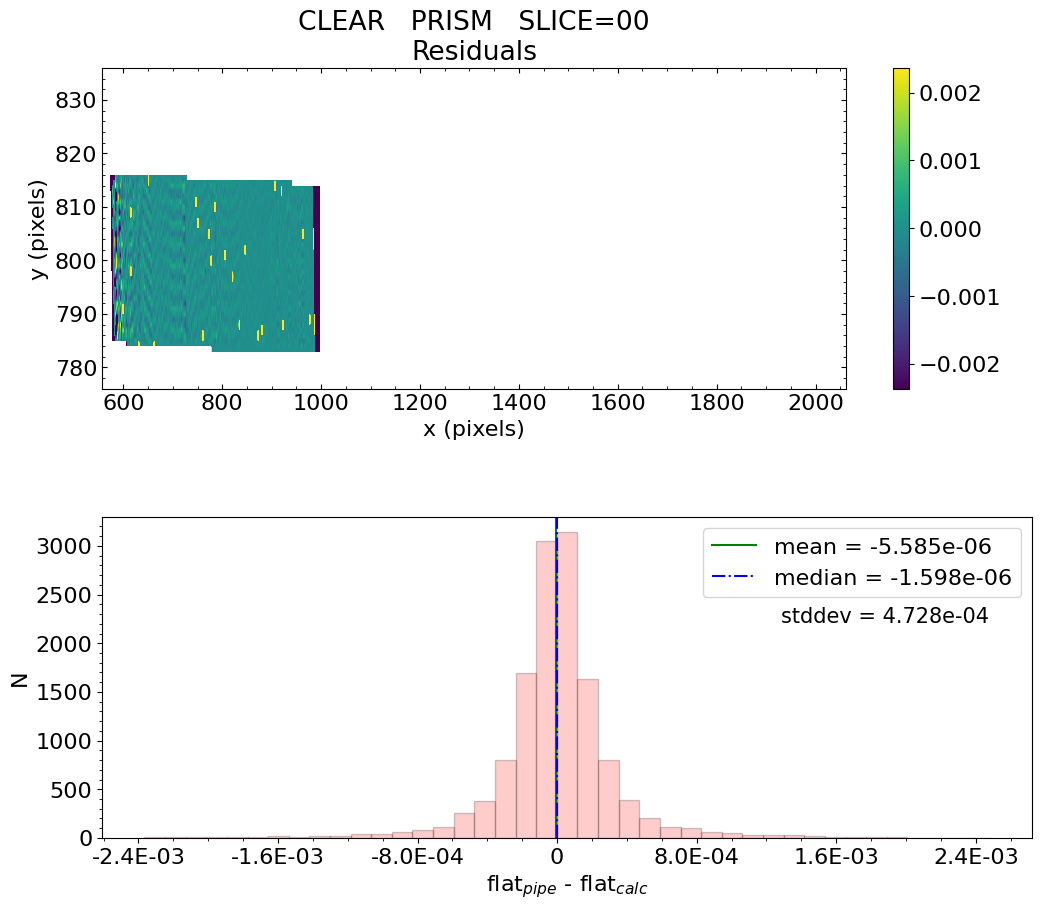

 *** Result of the test: PASSED


Working with slice: 01
 Subwindow origin:   px0=506   py0=1198
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 01

   Absolute Flat Difference  :   mean = 2.032e-06    median = 1.286e-06    stdev = 4.612e-04
    Maximum   AbsoluteFlat Difference = 6.883e-03
    Minimum   AbsoluteFlat Difference = -8.178e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


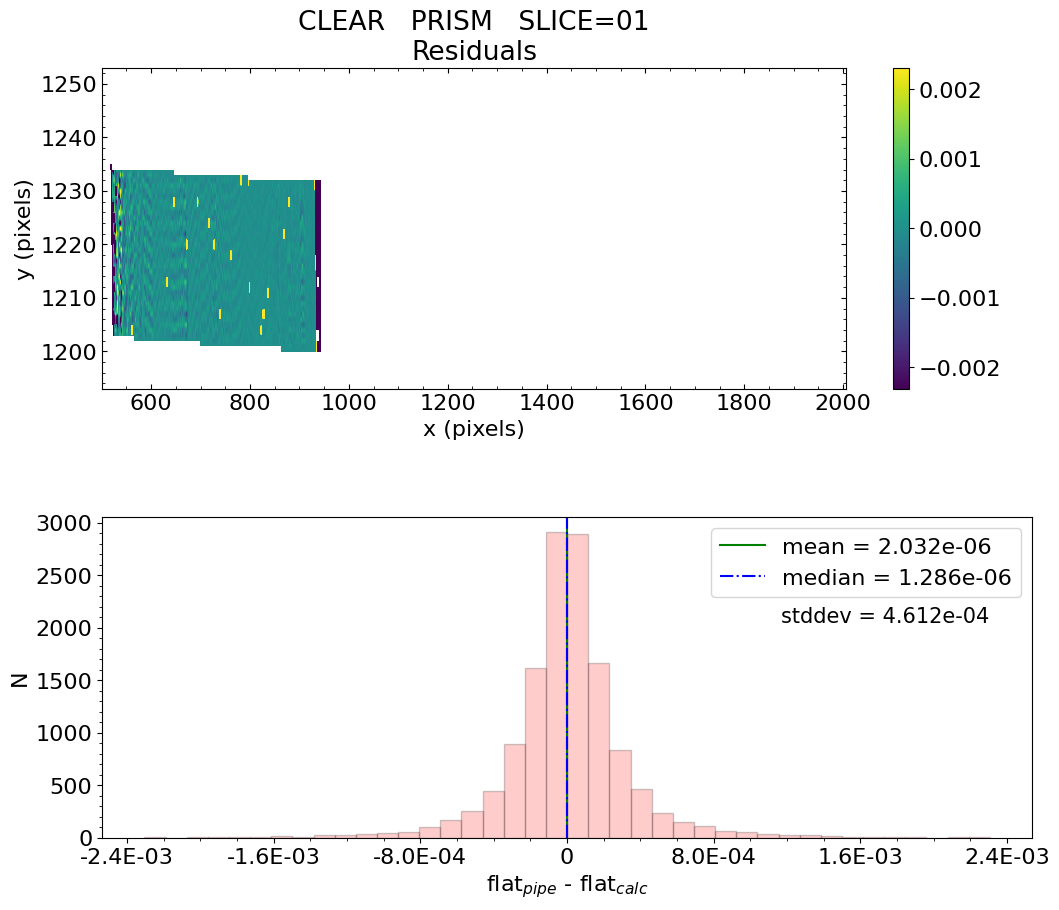

 *** Result of the test: PASSED


Working with slice: 02
 Subwindow origin:   px0=568   py0=731
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 02

   Absolute Flat Difference  :   mean = 7.401e-06    median = 4.806e-06    stdev = 4.664e-04
    Maximum   AbsoluteFlat Difference = 5.417e-03
    Minimum   AbsoluteFlat Difference = -8.054e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


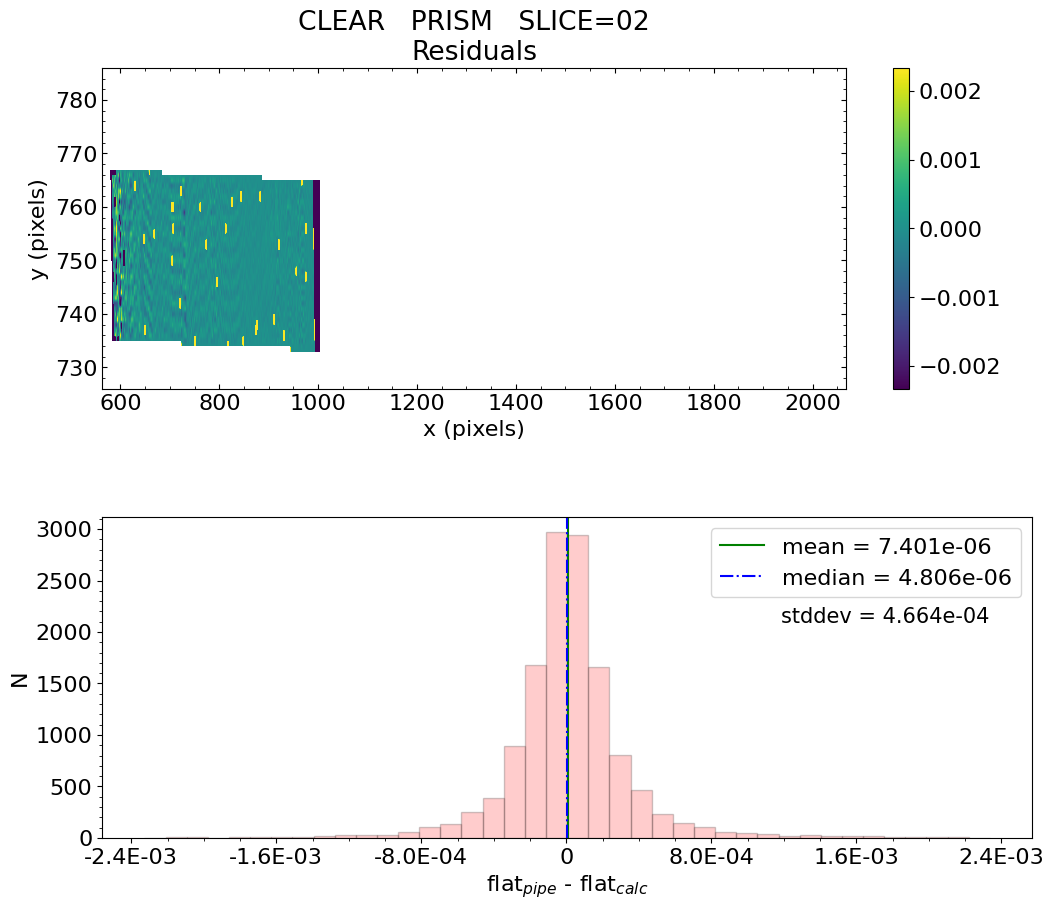

 *** Result of the test: PASSED


Working with slice: 03
 Subwindow origin:   px0=499   py0=1247
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 03

   Absolute Flat Difference  :   mean = 1.898e-06    median = 1.814e-07    stdev = 4.683e-04
    Maximum   AbsoluteFlat Difference = 6.185e-03
    Minimum   AbsoluteFlat Difference = -7.354e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


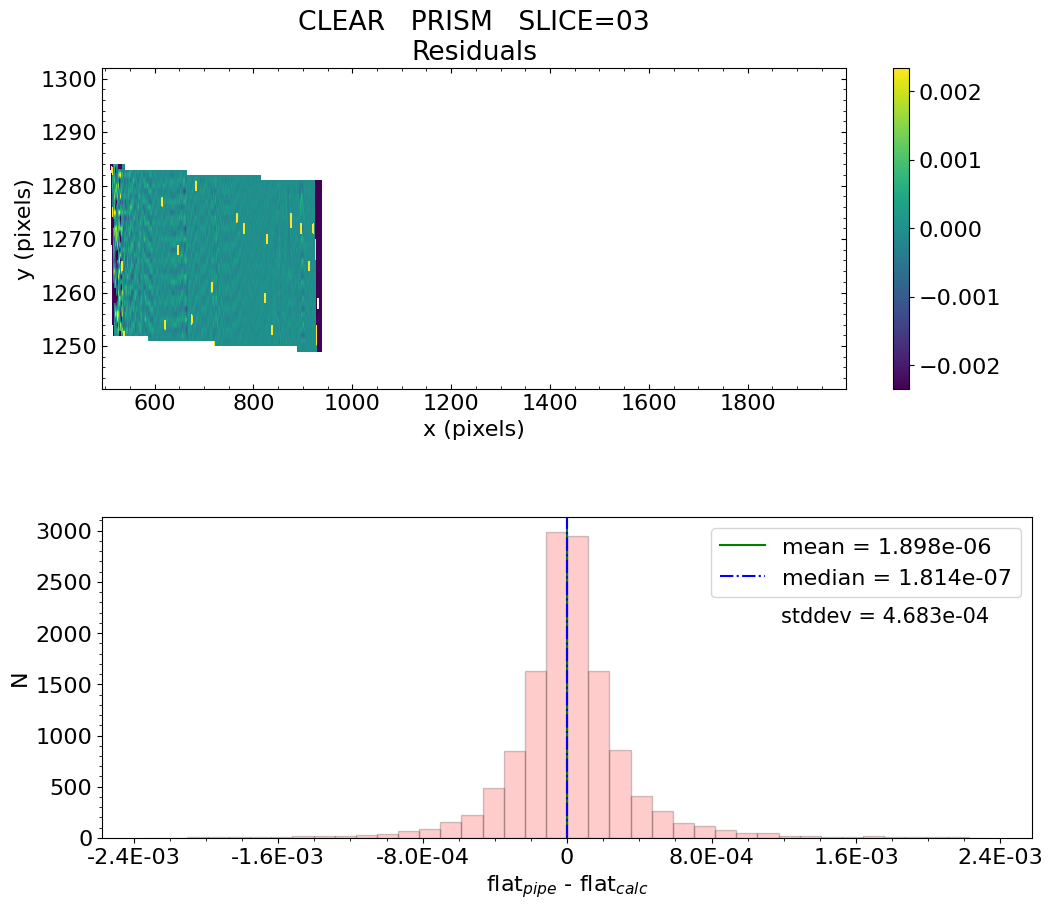

 *** Result of the test: PASSED


Working with slice: 04
 Subwindow origin:   px0=574   py0=682
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 04

   Absolute Flat Difference  :   mean = -5.143e-06    median = 6.561e-07    stdev = 4.649e-04
    Maximum   AbsoluteFlat Difference = 8.423e-03
    Minimum   AbsoluteFlat Difference = -1.048e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


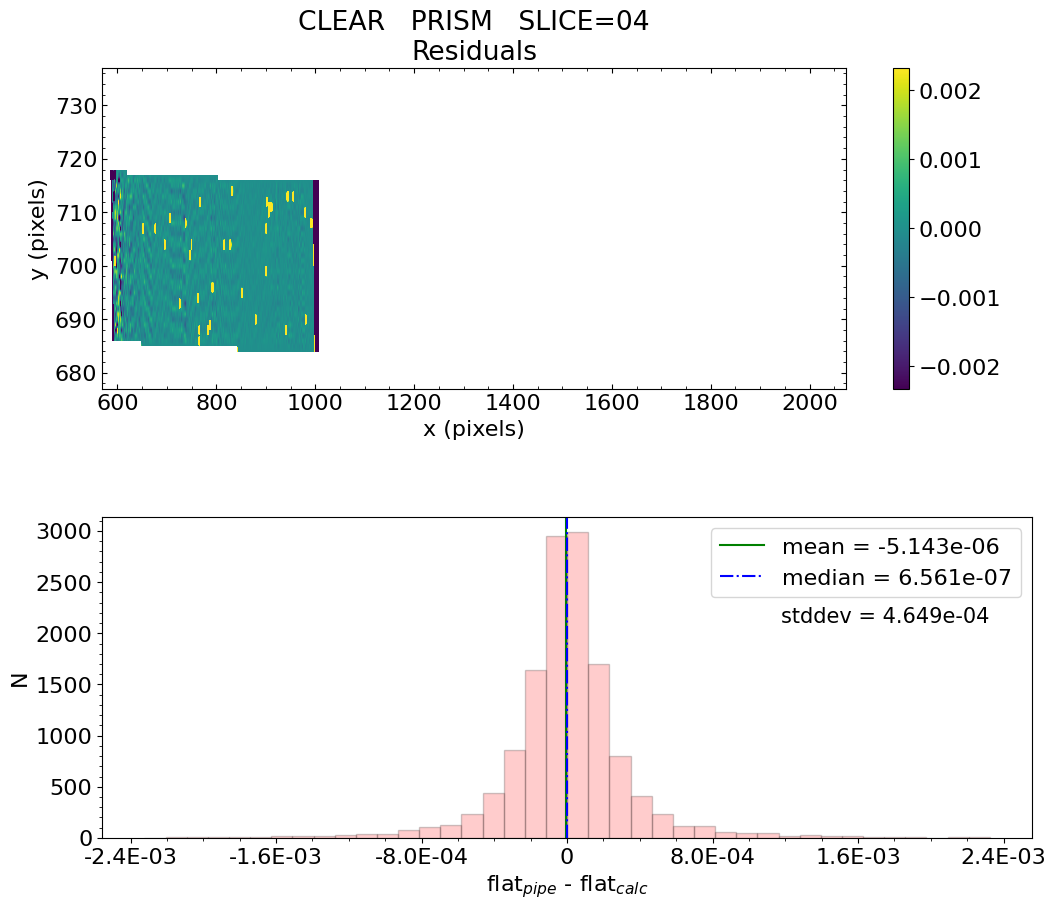

 *** Result of the test: PASSED


Working with slice: 05
 Subwindow origin:   px0=492   py0=1296
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 05

   Absolute Flat Difference  :   mean = 8.554e-07    median = 2.257e-06    stdev = 4.876e-04
    Maximum   AbsoluteFlat Difference = 4.968e-03
    Minimum   AbsoluteFlat Difference = -9.628e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


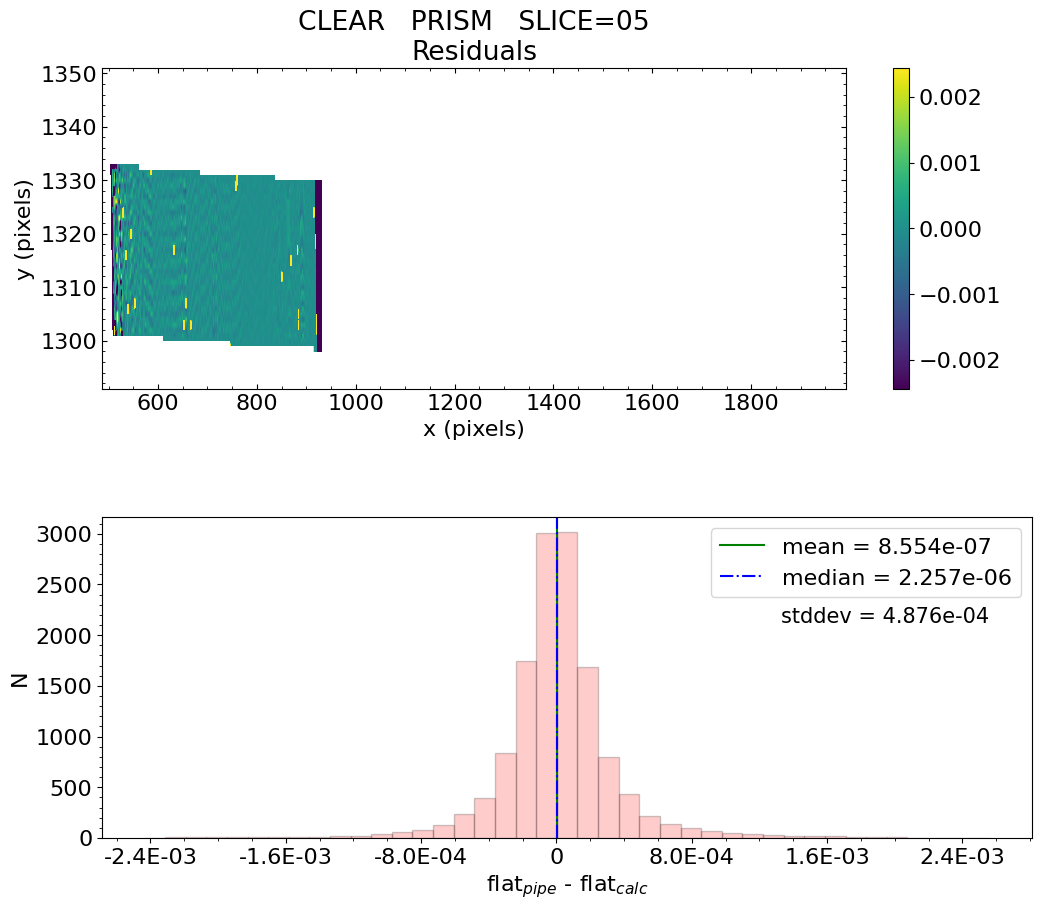

 *** Result of the test: PASSED


Working with slice: 06
 Subwindow origin:   px0=580   py0=633
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 06

   Absolute Flat Difference  :   mean = 1.528e-06    median = 6.108e-07    stdev = 4.948e-04
    Maximum   AbsoluteFlat Difference = 5.798e-03
    Minimum   AbsoluteFlat Difference = -9.827e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


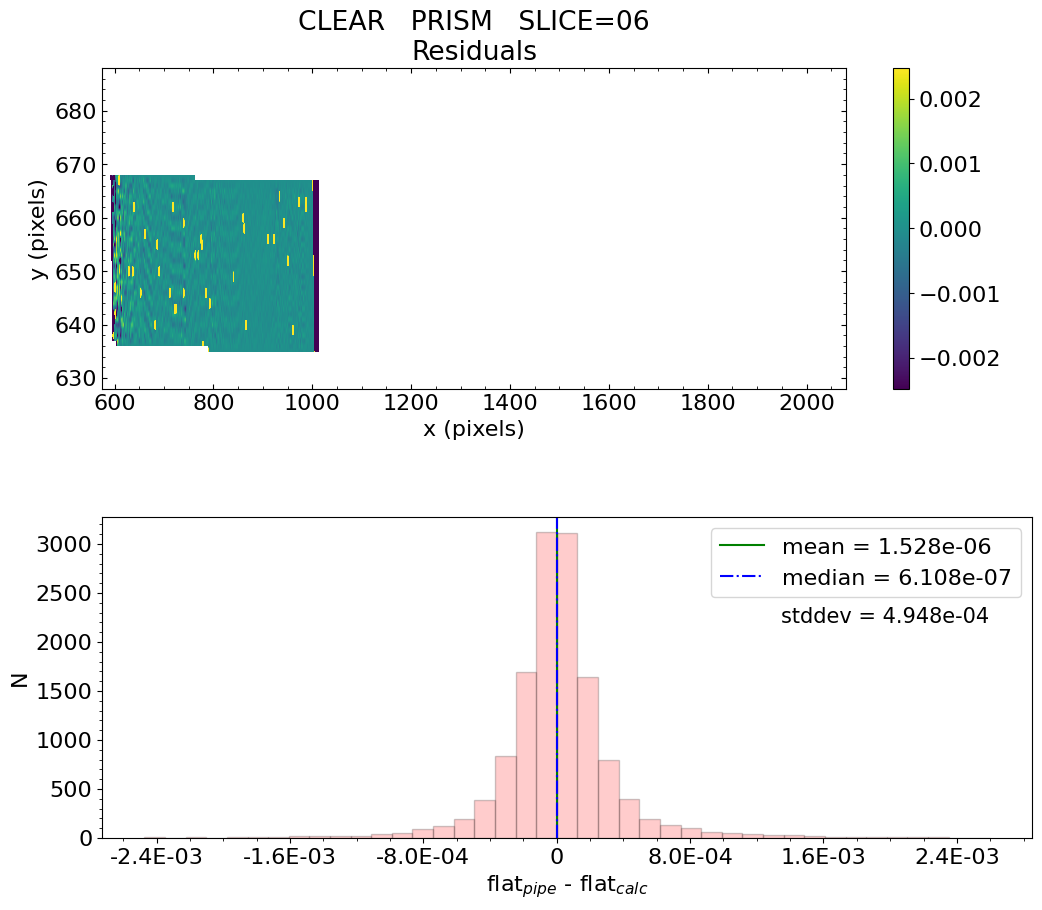

 *** Result of the test: PASSED


Working with slice: 07
 Subwindow origin:   px0=485   py0=1346
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 07

   Absolute Flat Difference  :   mean = -3.037e-06    median = 3.243e-07    stdev = 5.018e-04
    Maximum   AbsoluteFlat Difference = 5.995e-03
    Minimum   AbsoluteFlat Difference = -9.173e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


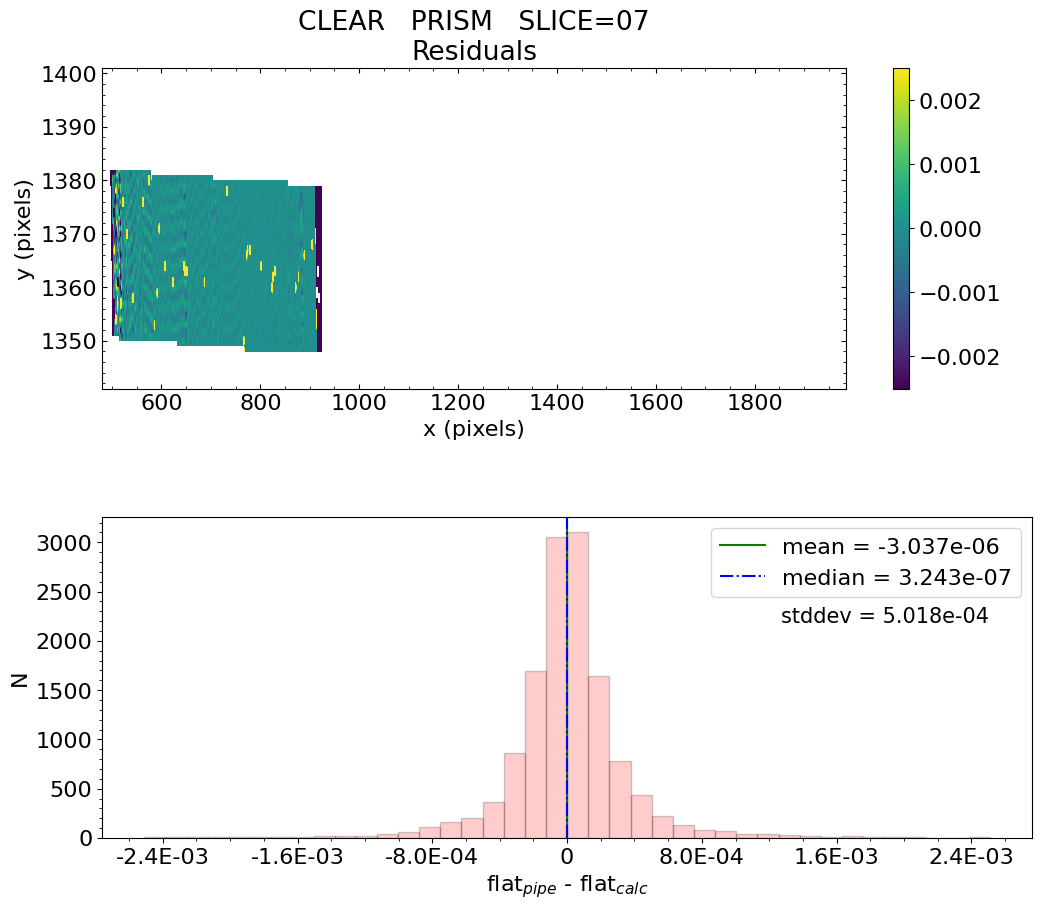

 *** Result of the test: PASSED


Working with slice: 08
 Subwindow origin:   px0=586   py0=583
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 08

   Absolute Flat Difference  :   mean = 6.086e-06    median = 1.095e-06    stdev = 5.003e-04
    Maximum   AbsoluteFlat Difference = 8.471e-03
    Minimum   AbsoluteFlat Difference = -8.025e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


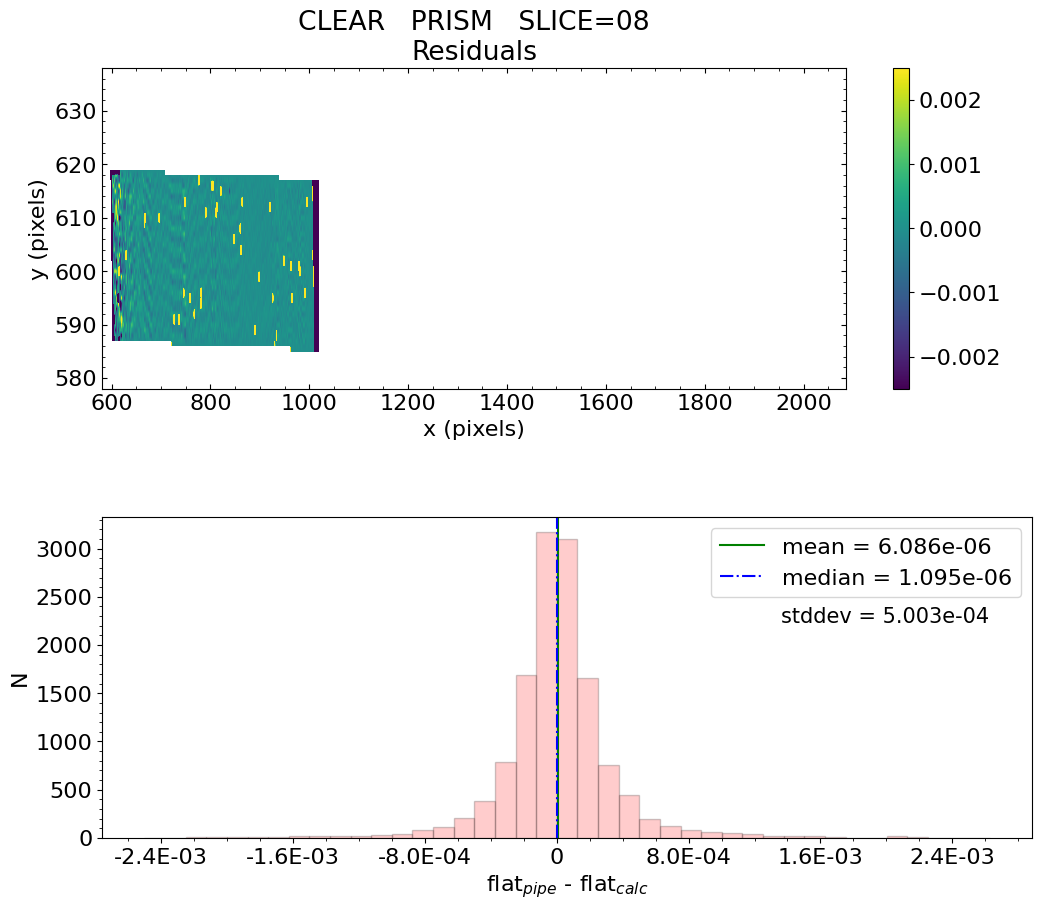

 *** Result of the test: PASSED


Working with slice: 09
 Subwindow origin:   px0=478   py0=1395
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 09

   Absolute Flat Difference  :   mean = 7.281e-07    median = 3.154e-06    stdev = 5.298e-04
    Maximum   AbsoluteFlat Difference = 6.824e-03
    Minimum   AbsoluteFlat Difference = -1.129e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


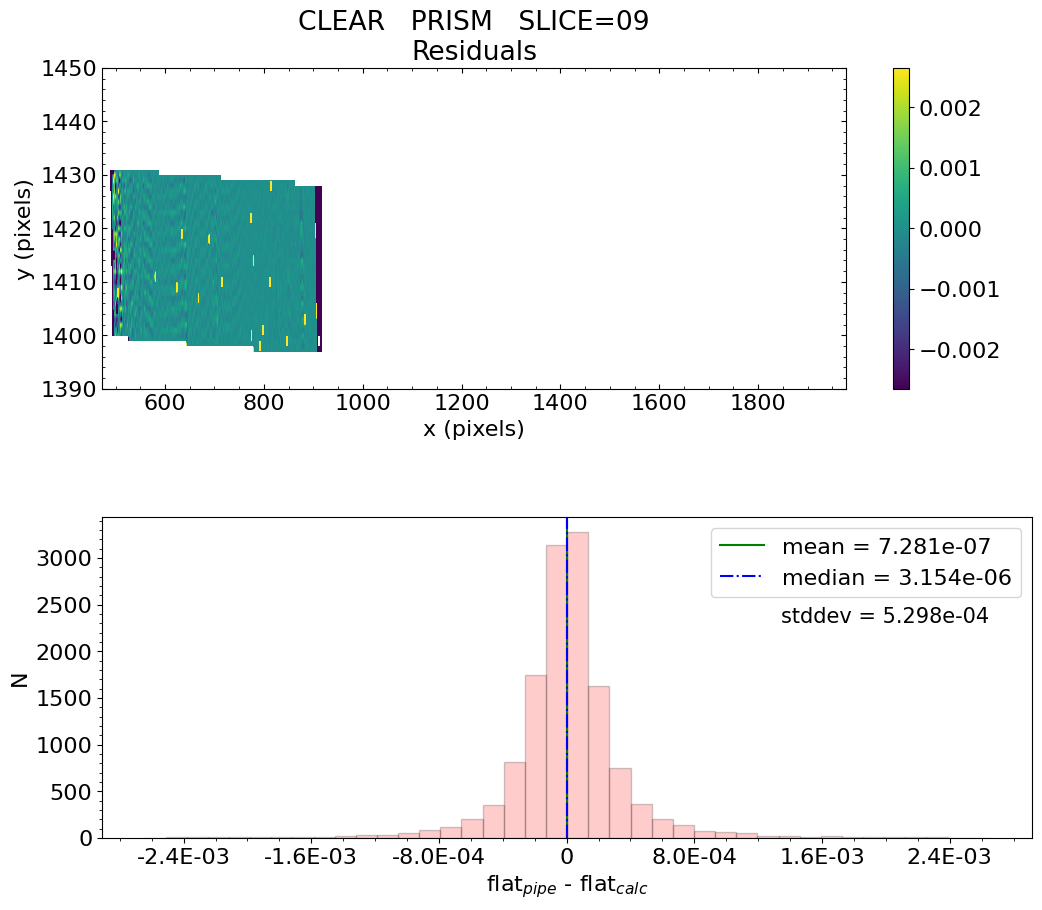

 *** Result of the test: PASSED


Working with slice: 10
 Subwindow origin:   px0=592   py0=534
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 10

   Absolute Flat Difference  :   mean = 8.475e-06    median = 1.662e-06    stdev = 5.347e-04
    Maximum   AbsoluteFlat Difference = 6.310e-03
    Minimum   AbsoluteFlat Difference = -1.228e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


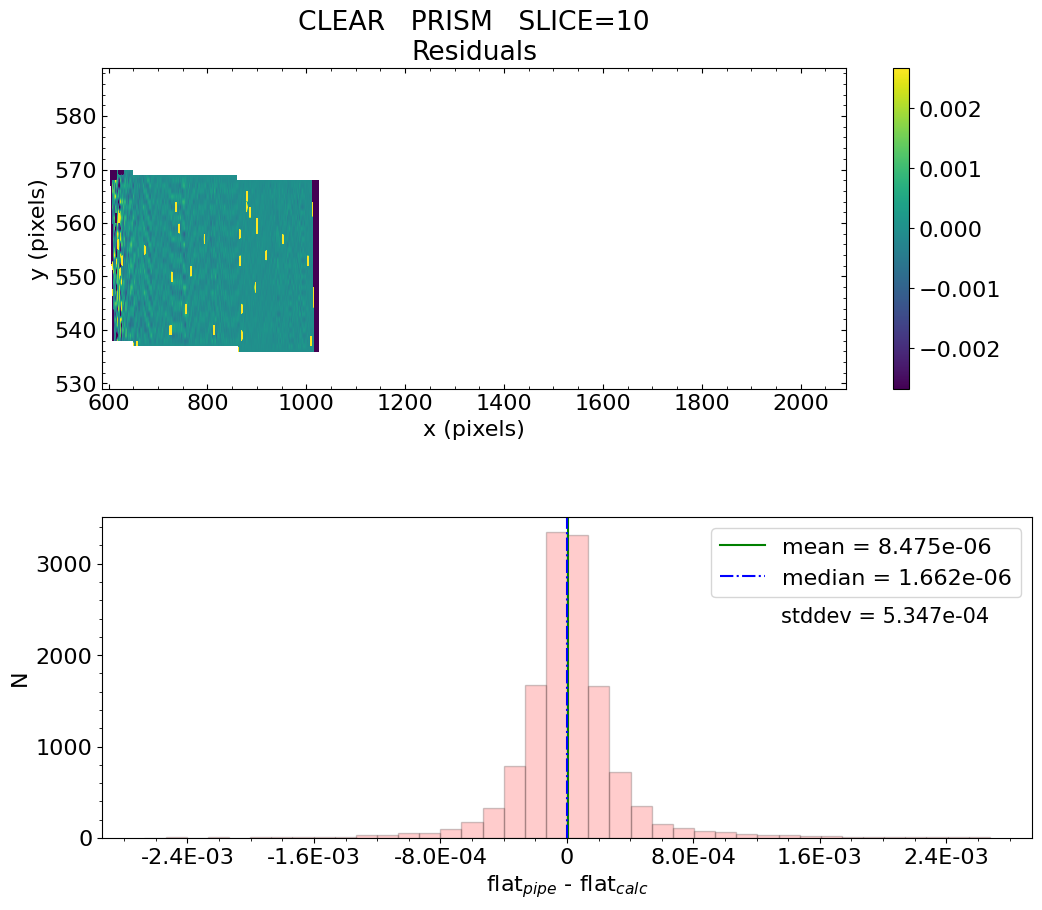

 *** Result of the test: PASSED


Working with slice: 11
 Subwindow origin:   px0=470   py0=1444
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 11

   Absolute Flat Difference  :   mean = -4.983e-07    median = 3.007e-06    stdev = 5.735e-04
    Maximum   AbsoluteFlat Difference = 7.259e-03
    Minimum   AbsoluteFlat Difference = -1.194e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


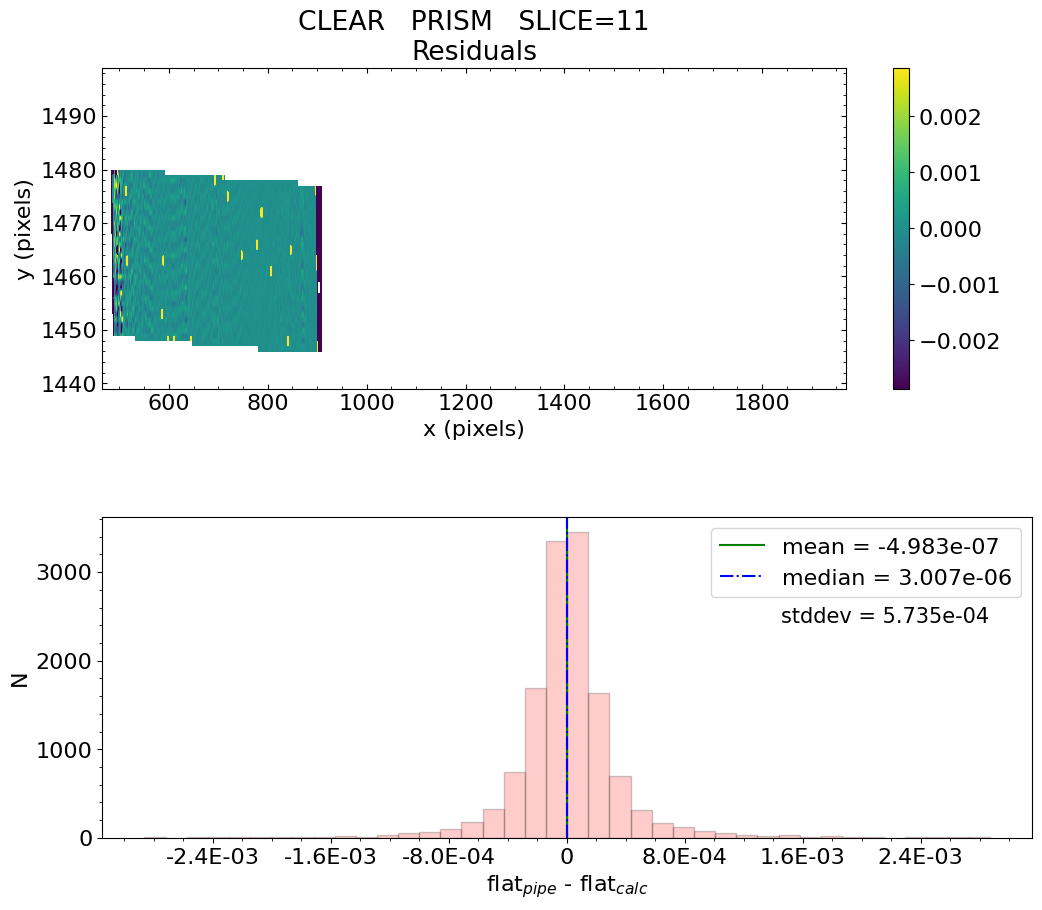

 *** Result of the test: PASSED


Working with slice: 12
 Subwindow origin:   px0=598   py0=485
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 12

   Absolute Flat Difference  :   mean = -6.266e-08    median = 3.942e-06    stdev = 5.423e-04
    Maximum   AbsoluteFlat Difference = 8.304e-03
    Minimum   AbsoluteFlat Difference = -1.426e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


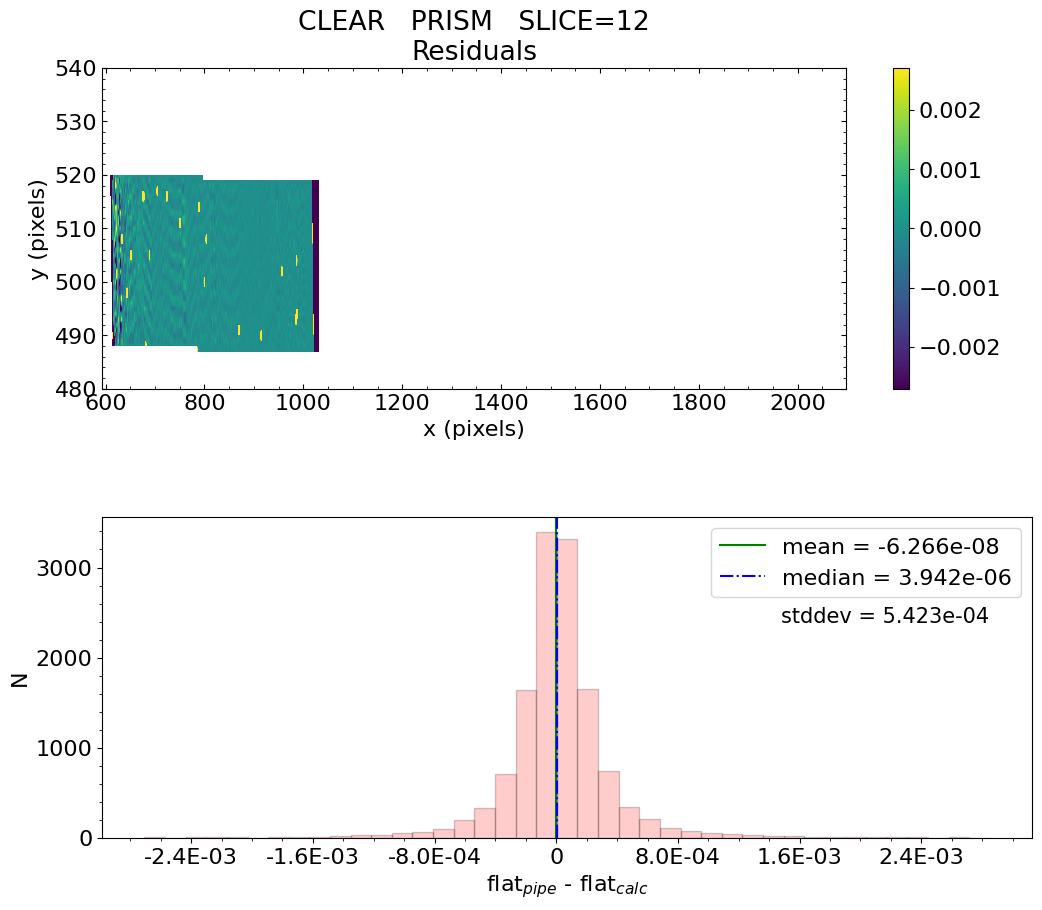

 *** Result of the test: PASSED


Working with slice: 13
 Subwindow origin:   px0=463   py0=1493
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 13

   Absolute Flat Difference  :   mean = -6.524e-06    median = 1.628e-06    stdev = 5.665e-04
    Maximum   AbsoluteFlat Difference = 7.729e-03
    Minimum   AbsoluteFlat Difference = -1.325e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


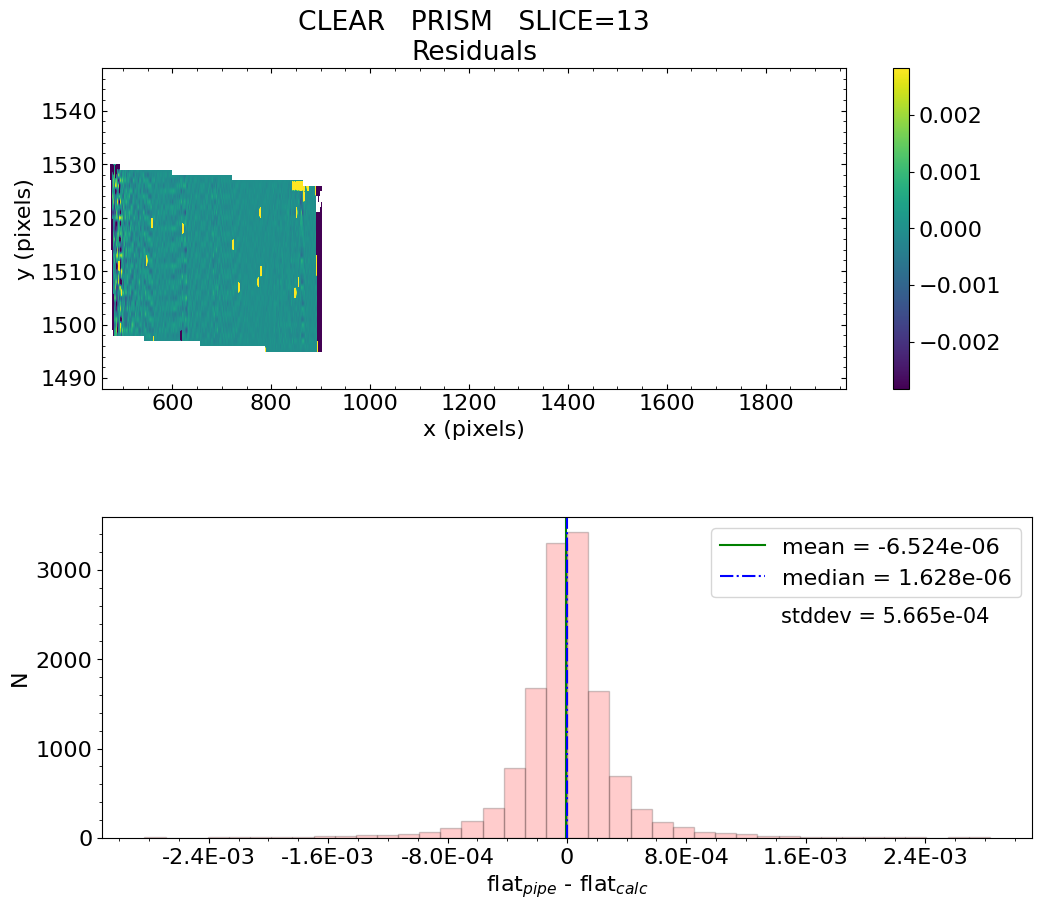

 *** Result of the test: PASSED


Working with slice: 14
 Subwindow origin:   px0=604   py0=435
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 14

   Absolute Flat Difference  :   mean = -6.613e-07    median = -5.511e-07    stdev = 5.185e-04
    Maximum   AbsoluteFlat Difference = 8.004e-03
    Minimum   AbsoluteFlat Difference = -8.879e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


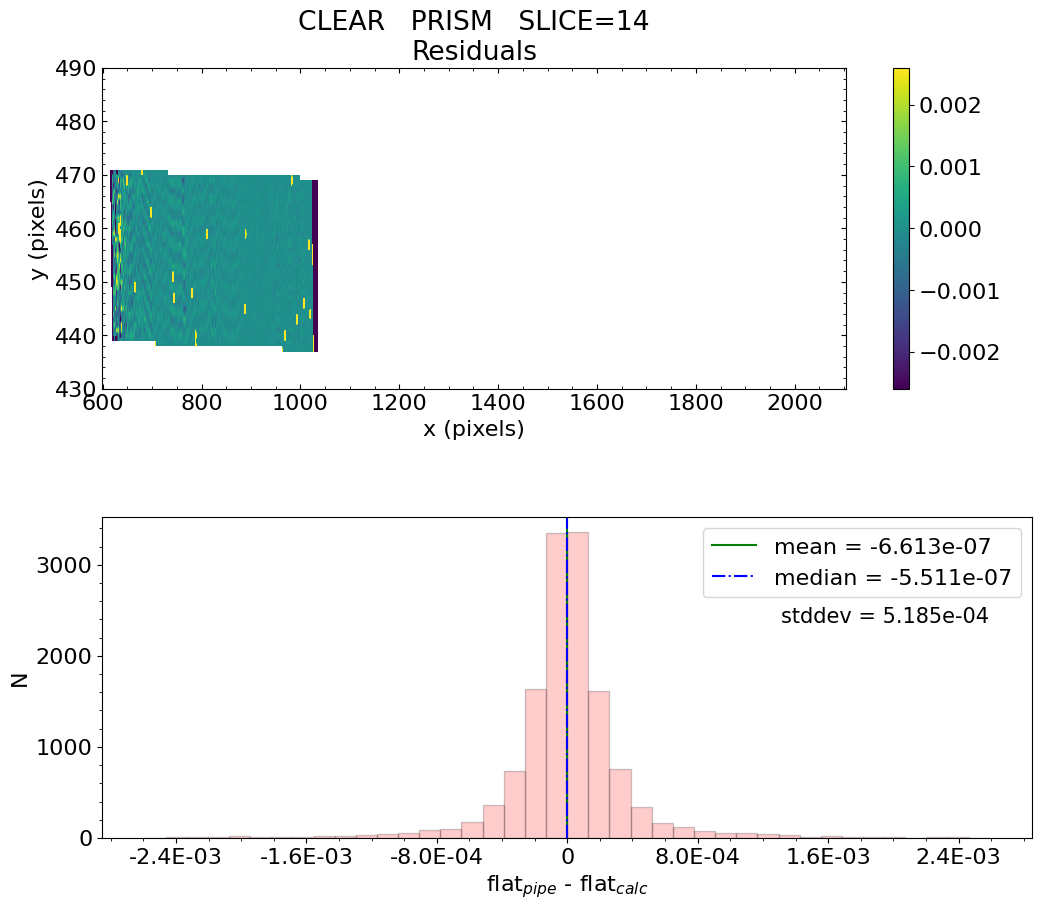

 *** Result of the test: PASSED


Working with slice: 15
 Subwindow origin:   px0=456   py0=1542
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 15

   Absolute Flat Difference  :   mean = 2.137e-06    median = 2.568e-06    stdev = 5.389e-04
    Maximum   AbsoluteFlat Difference = 8.162e-03
    Minimum   AbsoluteFlat Difference = -1.812e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


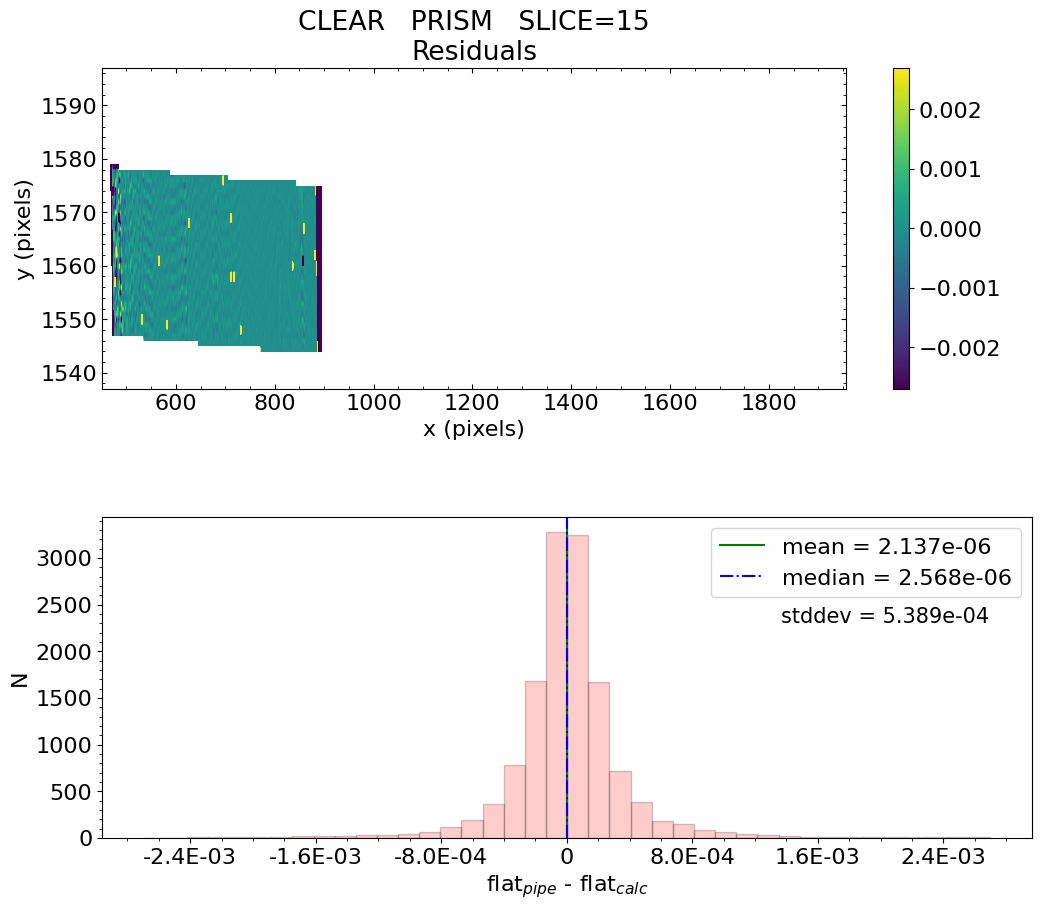

 *** Result of the test: PASSED


Working with slice: 16
 Subwindow origin:   px0=609   py0=386
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 16

   Absolute Flat Difference  :   mean = 1.091e-05    median = 2.507e-06    stdev = 5.111e-04
    Maximum   AbsoluteFlat Difference = 1.035e-02
    Minimum   AbsoluteFlat Difference = -1.015e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


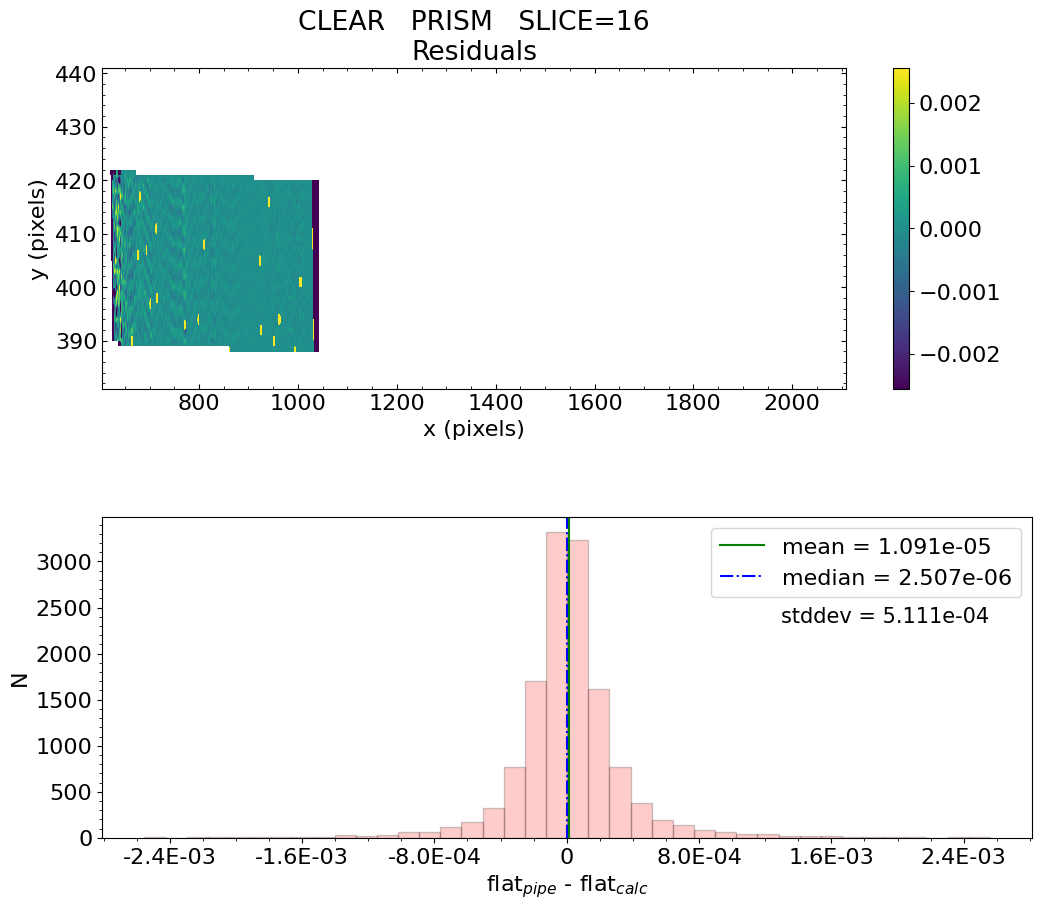

 *** Result of the test: PASSED


Working with slice: 17
 Subwindow origin:   px0=448   py0=1591
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 17

   Absolute Flat Difference  :   mean = 1.162e-05    median = 2.139e-06    stdev = 5.579e-04
    Maximum   AbsoluteFlat Difference = 8.790e-03
    Minimum   AbsoluteFlat Difference = -9.371e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


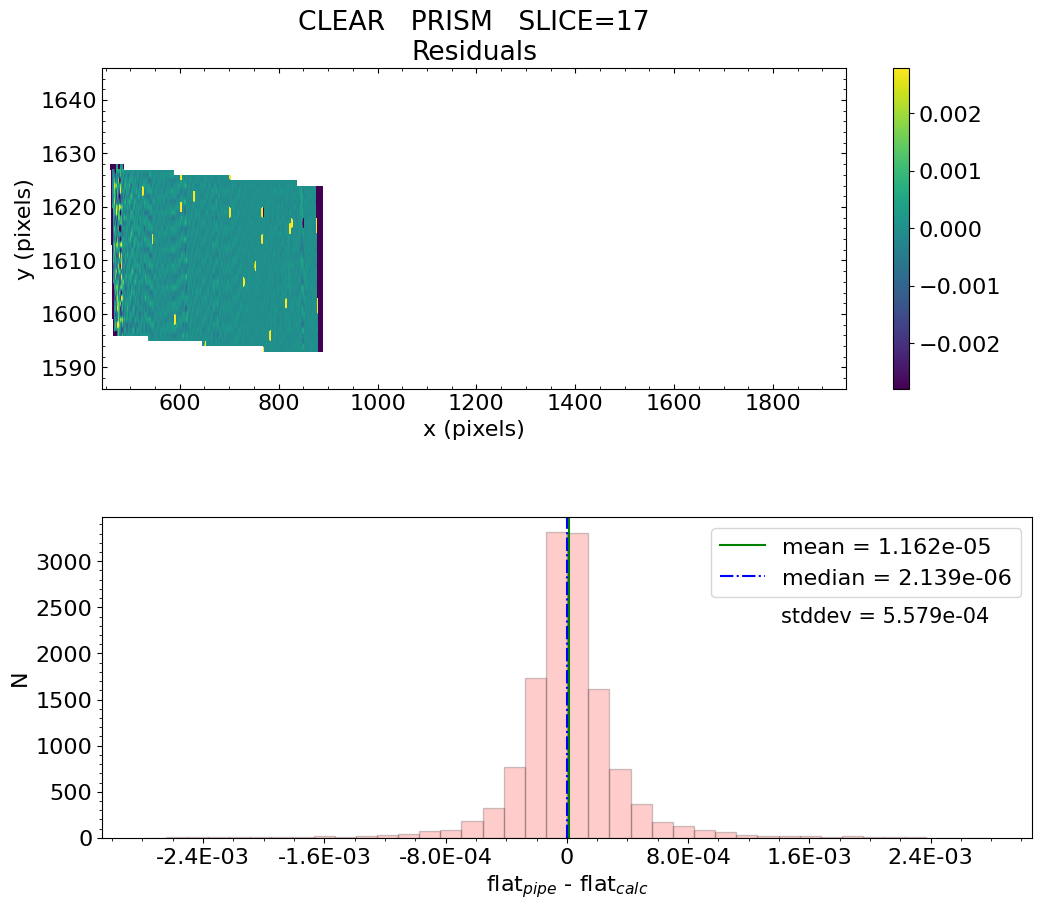

 *** Result of the test: PASSED


Working with slice: 18
 Subwindow origin:   px0=615   py0=337
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 18

   Absolute Flat Difference  :   mean = 5.131e-06    median = 6.407e-08    stdev = 4.918e-04
    Maximum   AbsoluteFlat Difference = 6.088e-03
    Minimum   AbsoluteFlat Difference = -9.723e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


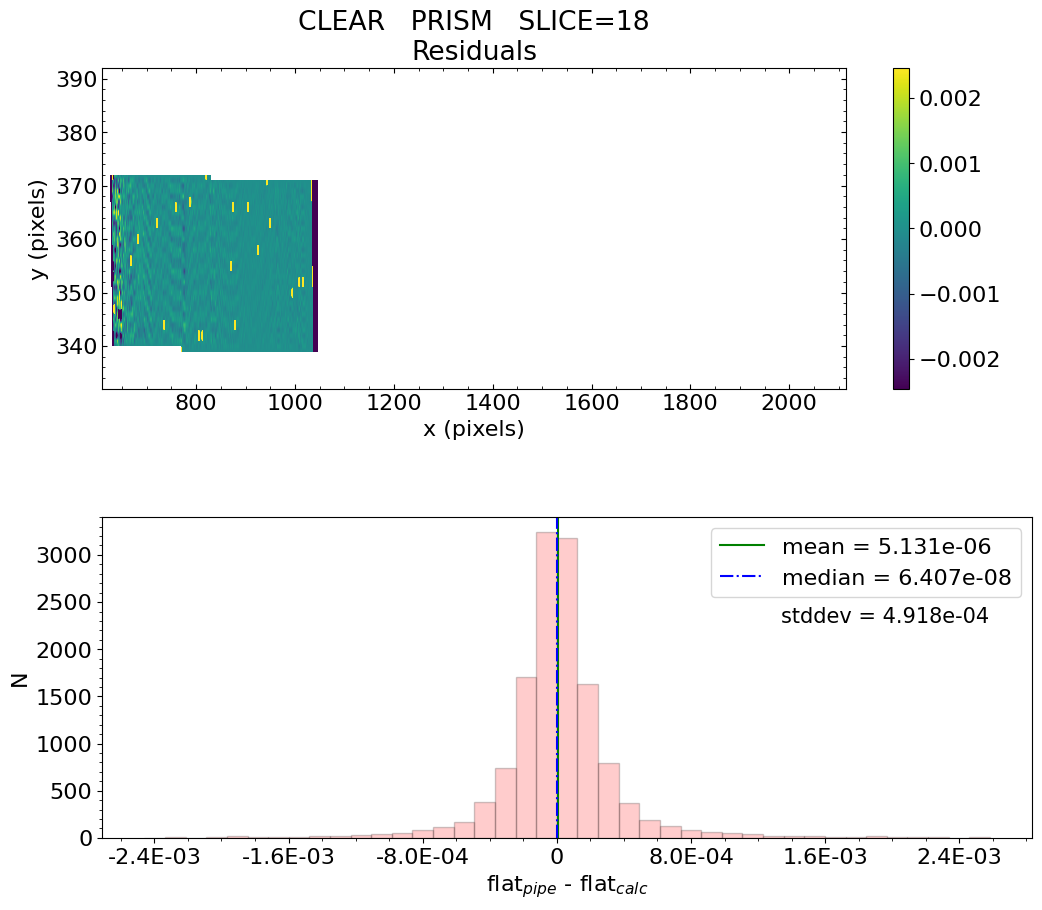

 *** Result of the test: PASSED


Working with slice: 19
 Subwindow origin:   px0=441   py0=1640
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 19

   Absolute Flat Difference  :   mean = -2.600e-06    median = -1.695e-06    stdev = 5.171e-04
    Maximum   AbsoluteFlat Difference = 9.488e-03
    Minimum   AbsoluteFlat Difference = -7.162e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


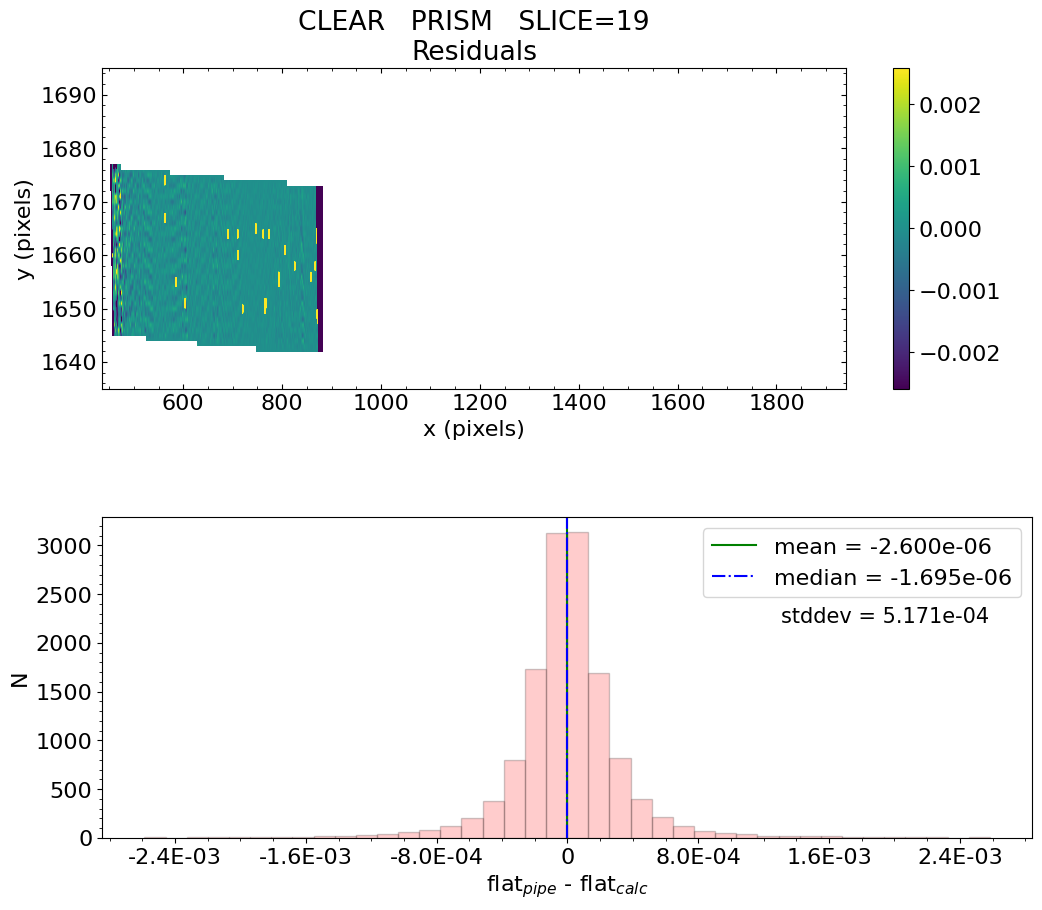

 *** Result of the test: PASSED


Working with slice: 20
 Subwindow origin:   px0=620   py0=287
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 20

   Absolute Flat Difference  :   mean = 2.028e-06    median = 4.515e-07    stdev = 4.695e-04
    Maximum   AbsoluteFlat Difference = 5.667e-03
    Minimum   AbsoluteFlat Difference = -1.161e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


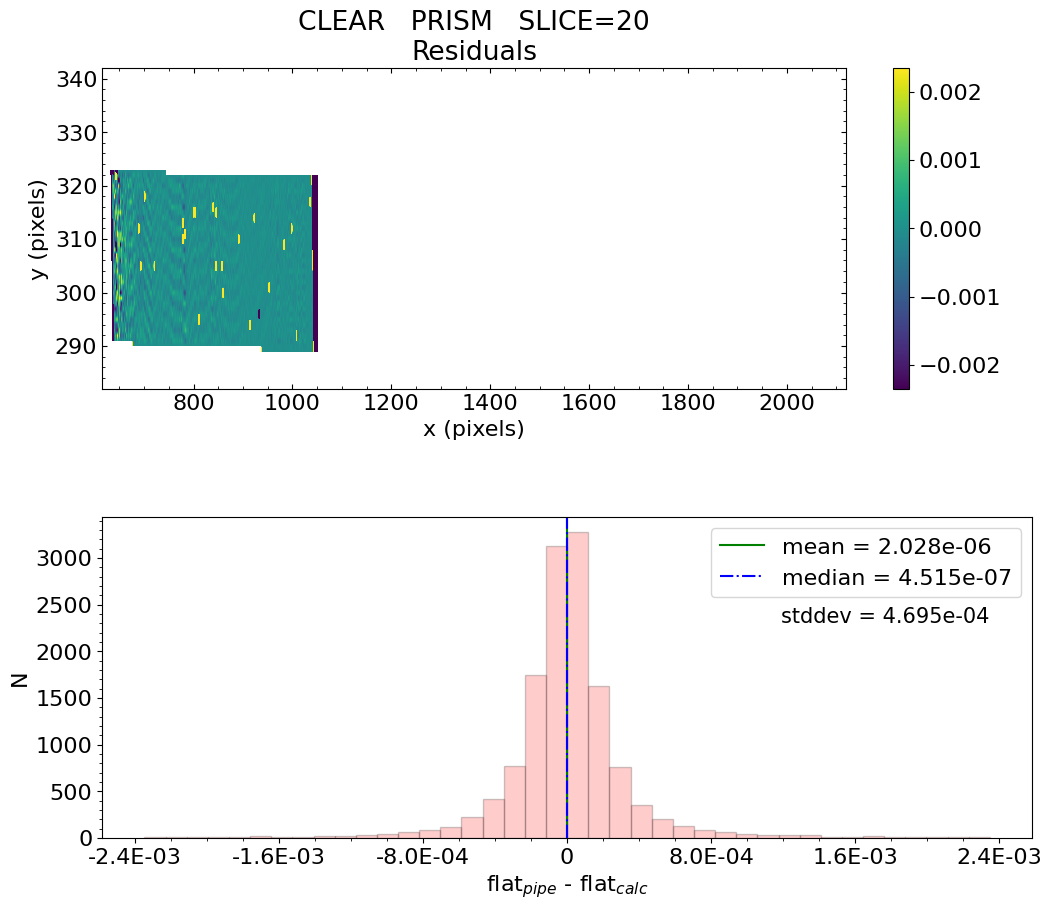

 *** Result of the test: PASSED


Working with slice: 21
 Subwindow origin:   px0=433   py0=1689
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 21

   Absolute Flat Difference  :   mean = 4.217e-06    median = 1.705e-06    stdev = 5.407e-04
    Maximum   AbsoluteFlat Difference = 8.381e-03
    Minimum   AbsoluteFlat Difference = -1.063e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


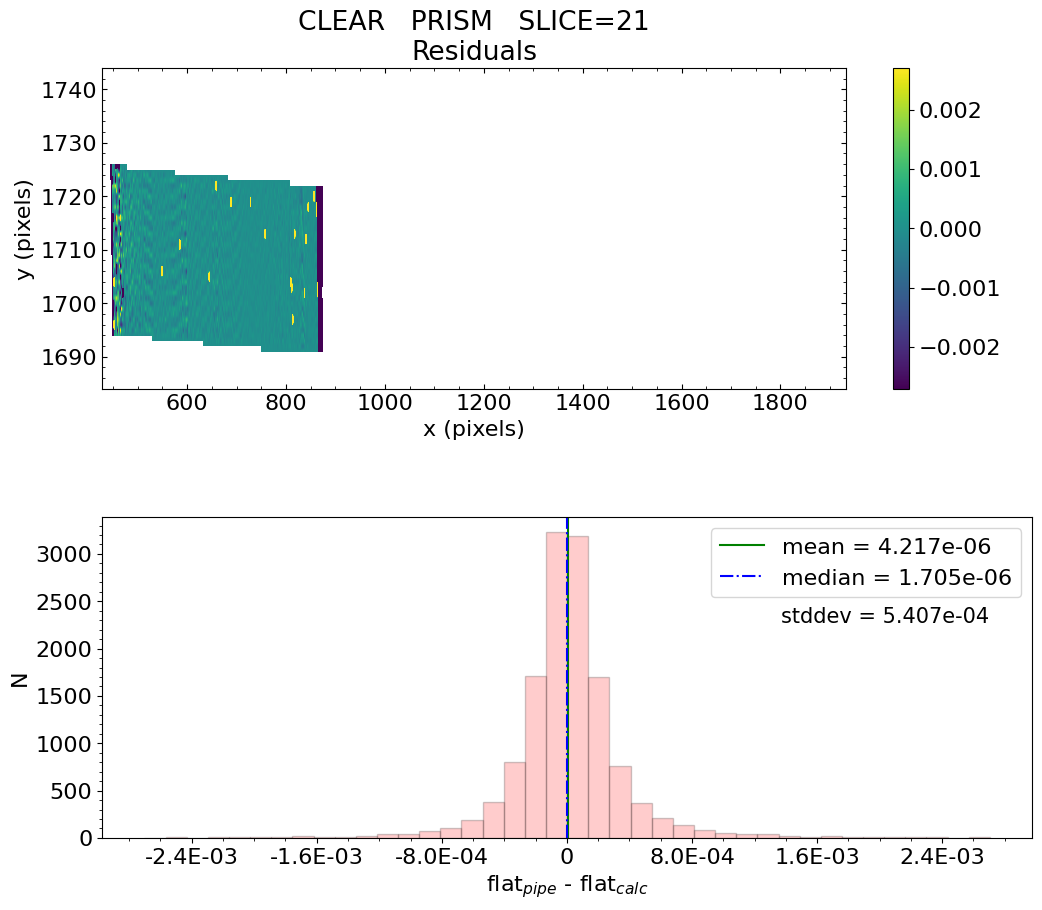

 *** Result of the test: PASSED


Working with slice: 22
 Subwindow origin:   px0=626   py0=238
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 22

   Absolute Flat Difference  :   mean = -7.086e-06    median = 4.637e-07    stdev = 6.329e-04
    Maximum   AbsoluteFlat Difference = 7.837e-03
    Minimum   AbsoluteFlat Difference = -4.442e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


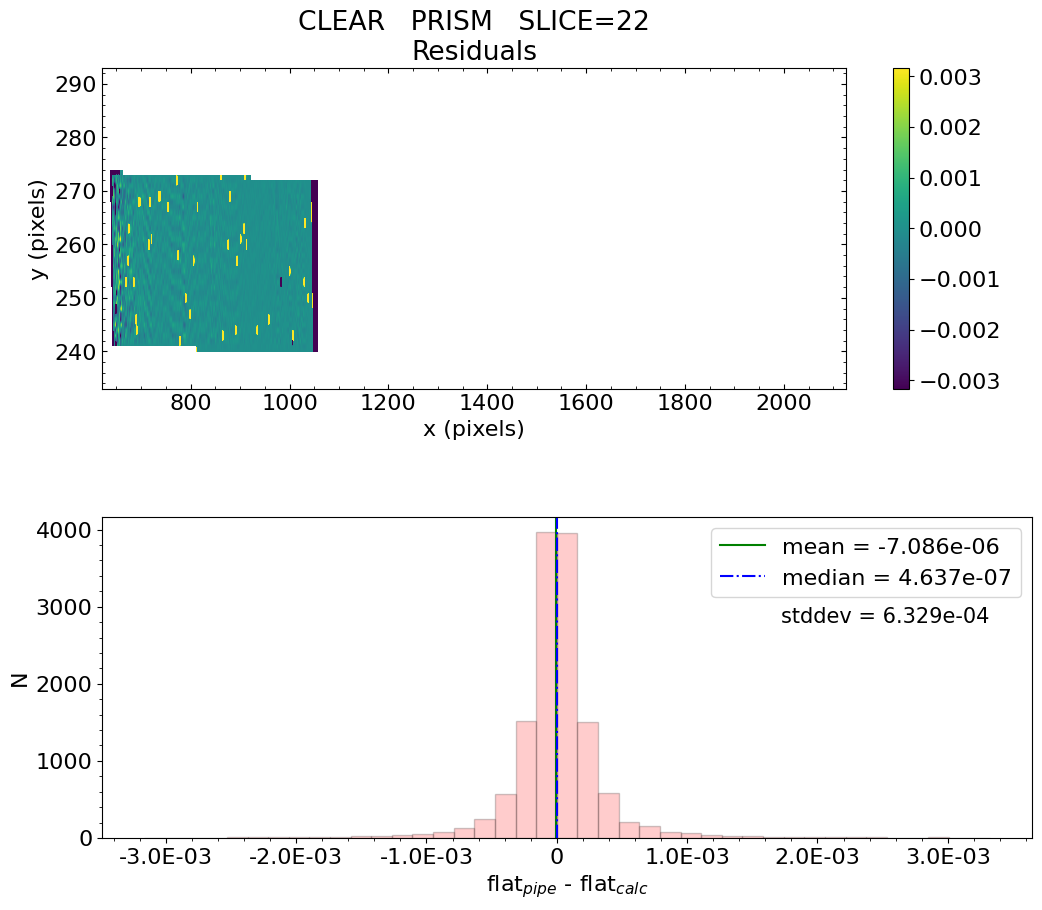

 *** Result of the test: PASSED


Working with slice: 23
 Subwindow origin:   px0=425   py0=1738
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 23

   Absolute Flat Difference  :   mean = 7.341e-06    median = 1.651e-06    stdev = 5.083e-04
    Maximum   AbsoluteFlat Difference = 6.686e-03
    Minimum   AbsoluteFlat Difference = -1.136e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


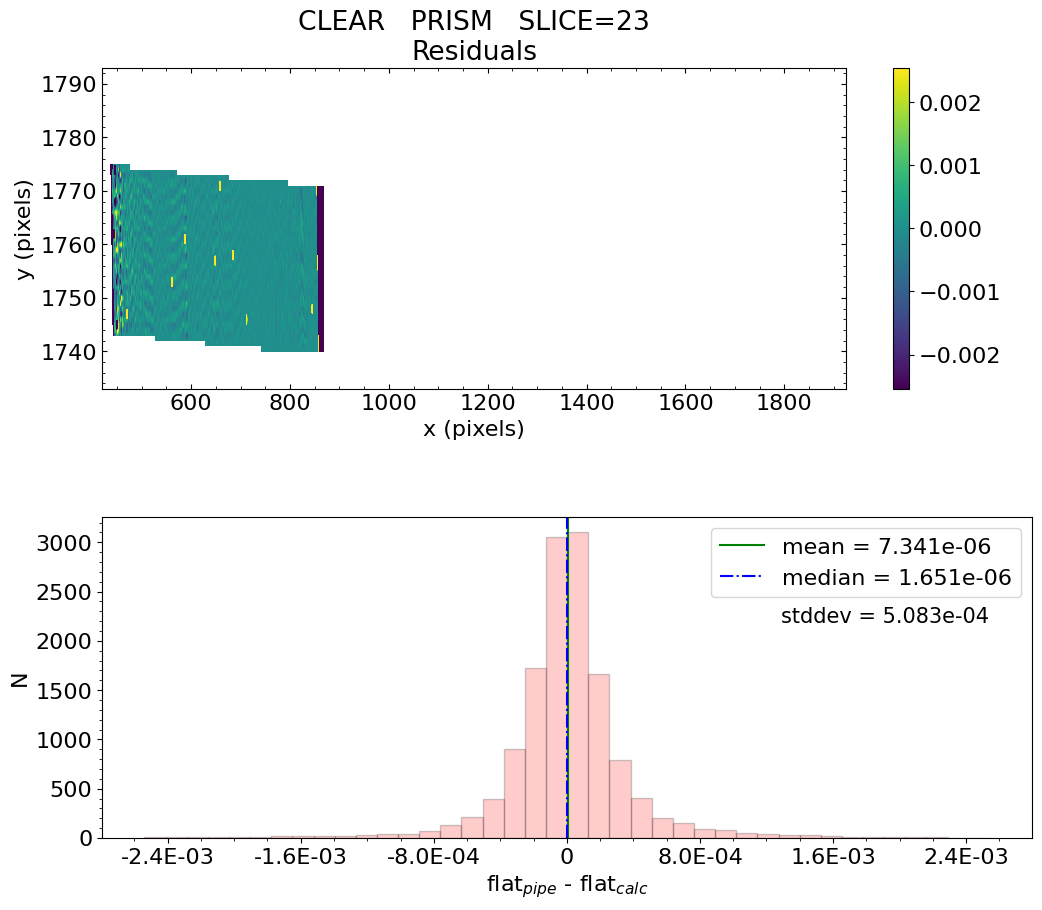

 *** Result of the test: PASSED


Working with slice: 24
 Subwindow origin:   px0=631   py0=188
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 24

   Absolute Flat Difference  :   mean = 7.142e-06    median = 2.250e-06    stdev = 4.728e-04
    Maximum   AbsoluteFlat Difference = 6.487e-03
    Minimum   AbsoluteFlat Difference = -1.016e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


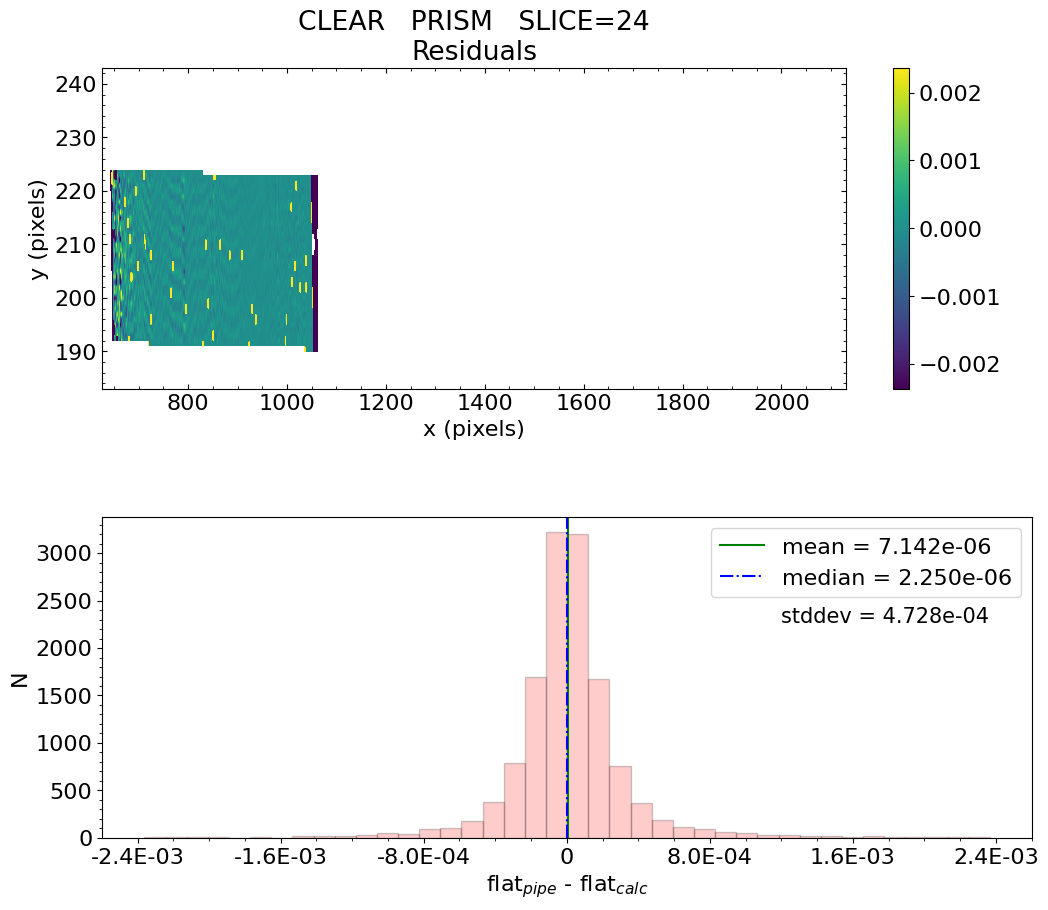

 *** Result of the test: PASSED


Working with slice: 25
 Subwindow origin:   px0=417   py0=1786
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 25

   Absolute Flat Difference  :   mean = -3.638e-07    median = 2.304e-06    stdev = 5.080e-04
    Maximum   AbsoluteFlat Difference = 7.542e-03
    Minimum   AbsoluteFlat Difference = -9.453e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


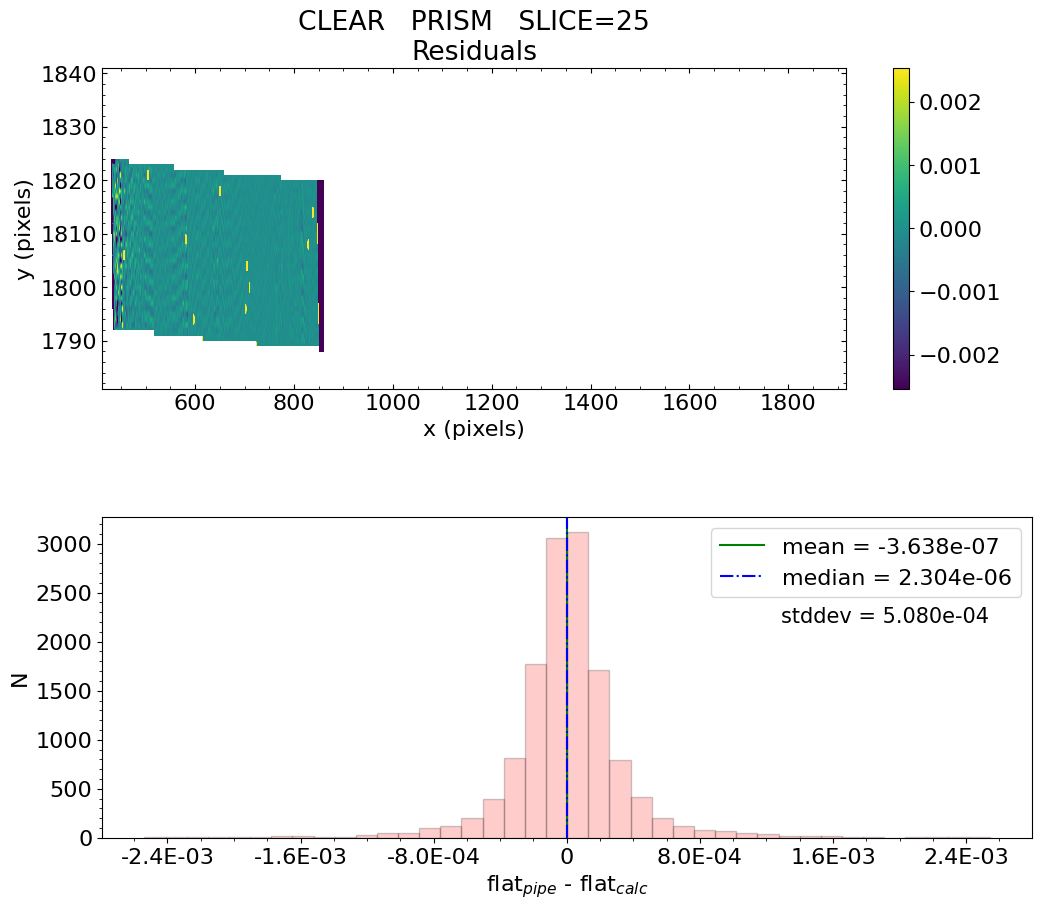

 *** Result of the test: PASSED


Working with slice: 26
 Subwindow origin:   px0=636   py0=139
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 26

   Absolute Flat Difference  :   mean = 2.085e-06    median = 5.087e-07    stdev = 4.648e-04
    Maximum   AbsoluteFlat Difference = 8.256e-03
    Minimum   AbsoluteFlat Difference = -1.013e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


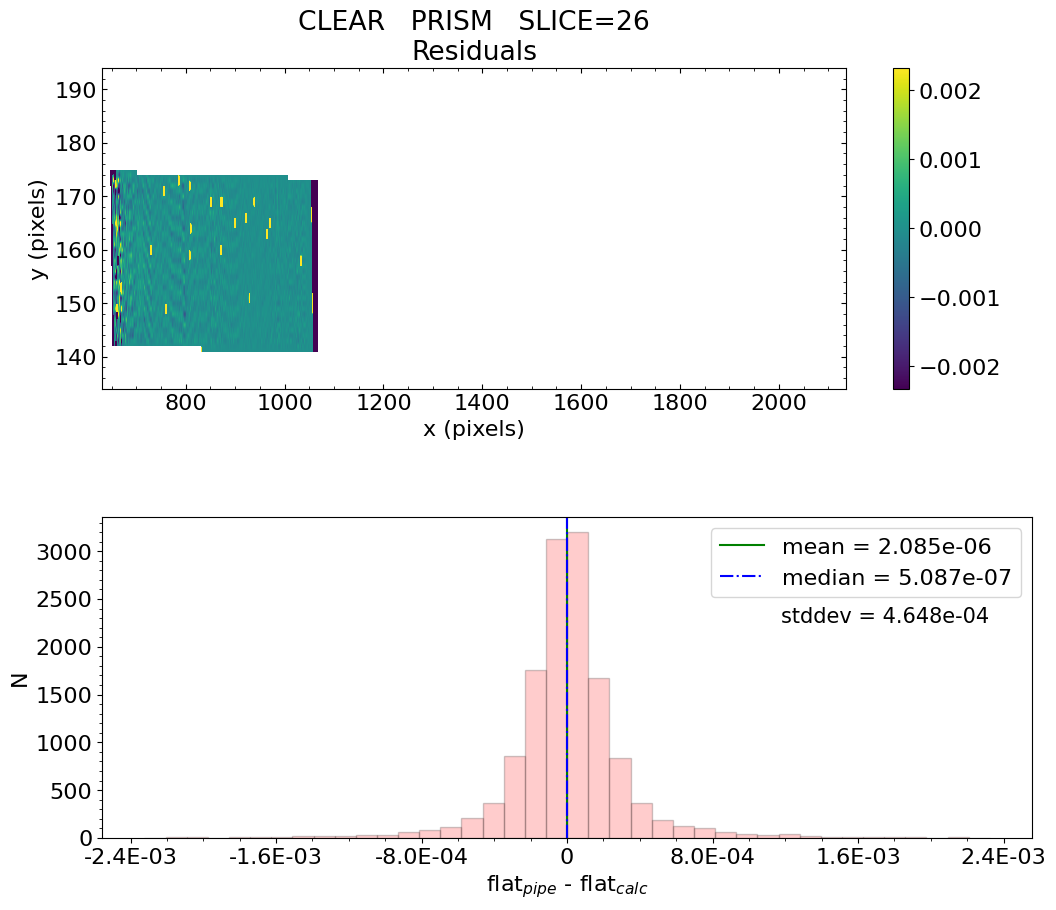

 *** Result of the test: PASSED


Working with slice: 27
 Subwindow origin:   px0=409   py0=1835
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 27

   Absolute Flat Difference  :   mean = 4.815e-07    median = -6.314e-07    stdev = 5.132e-04
    Maximum   AbsoluteFlat Difference = 7.667e-03
    Minimum   AbsoluteFlat Difference = -9.992e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


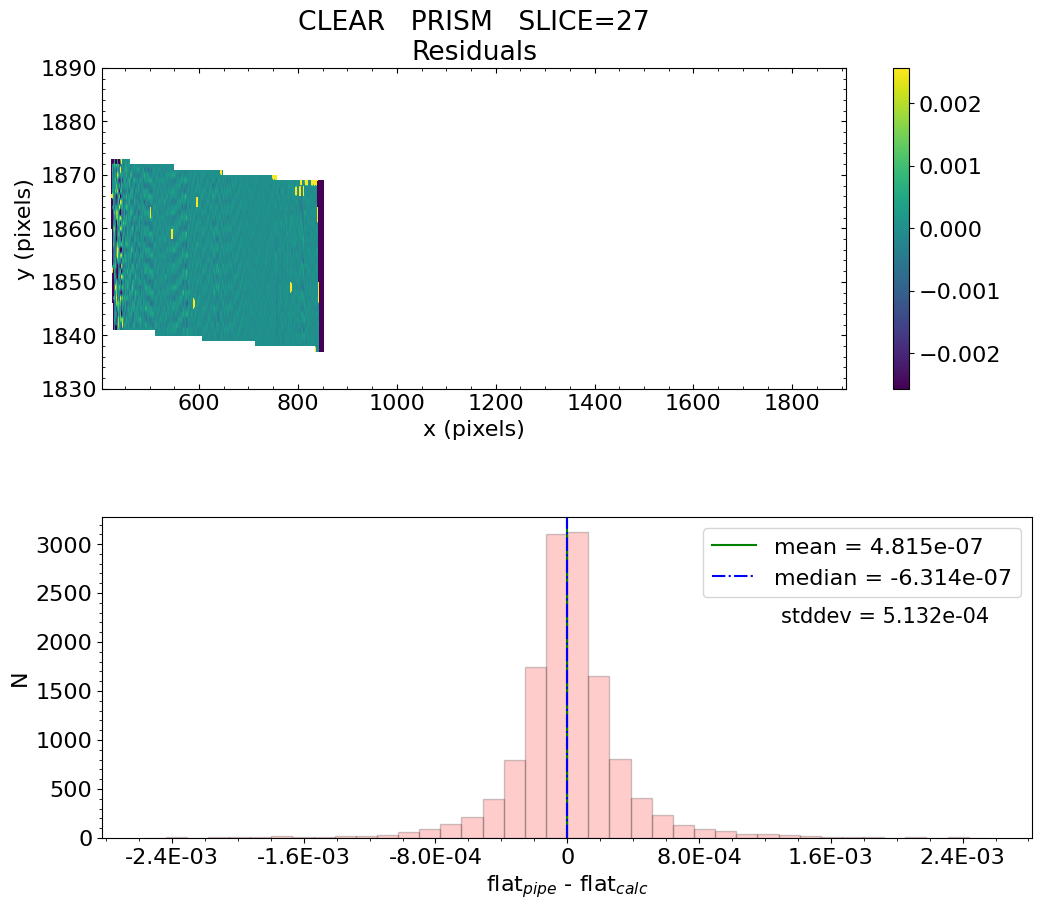

 *** Result of the test: PASSED


Working with slice: 28
 Subwindow origin:   px0=641   py0=89
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 28

   Absolute Flat Difference  :   mean = -6.704e-06    median = -3.939e-07    stdev = 4.897e-04
    Maximum   AbsoluteFlat Difference = 6.545e-03
    Minimum   AbsoluteFlat Difference = -9.064e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


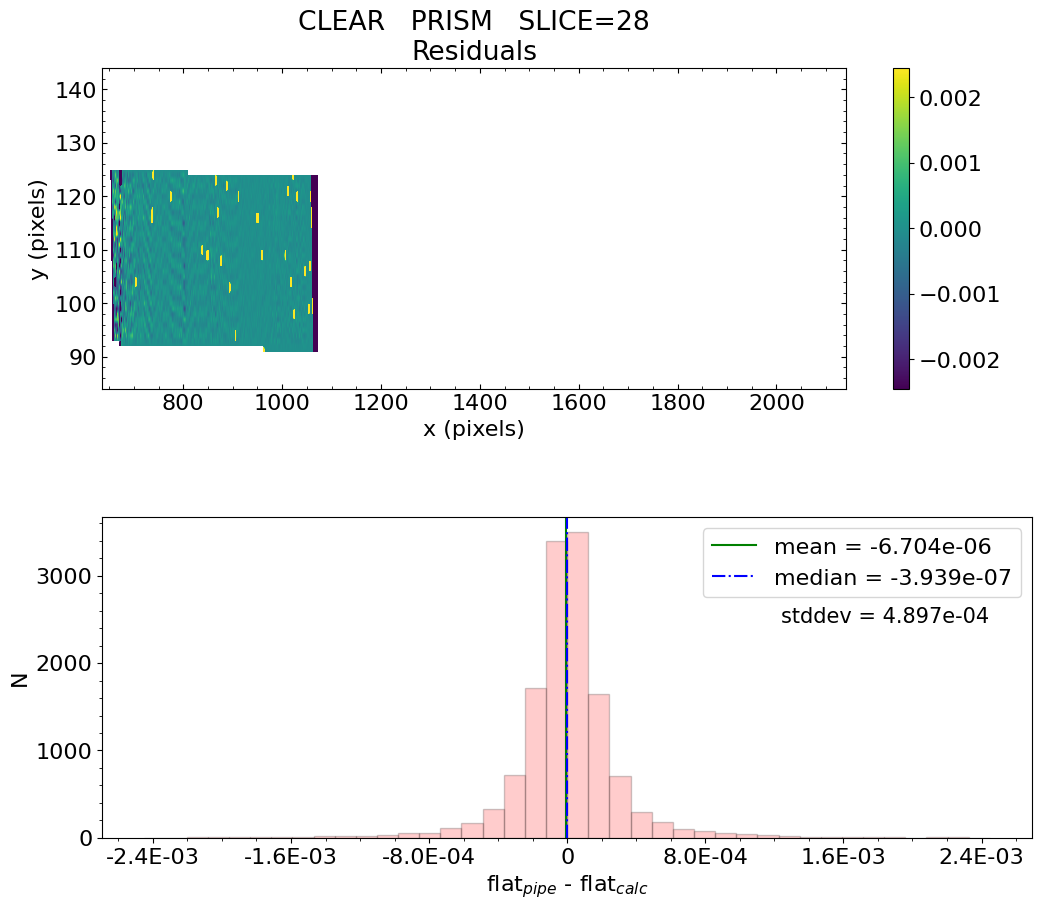

 *** Result of the test: PASSED


Working with slice: 29
 Subwindow origin:   px0=402   py0=1884
 Looping through the wavelength, this may take a little time ... 


Flat value differences for slice number: 29

   Absolute Flat Difference  :   mean = -3.939e-06    median = 2.309e-06    stdev = 5.417e-04
    Maximum   AbsoluteFlat Difference = 7.232e-03
    Minimum   AbsoluteFlat Difference = -1.895e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


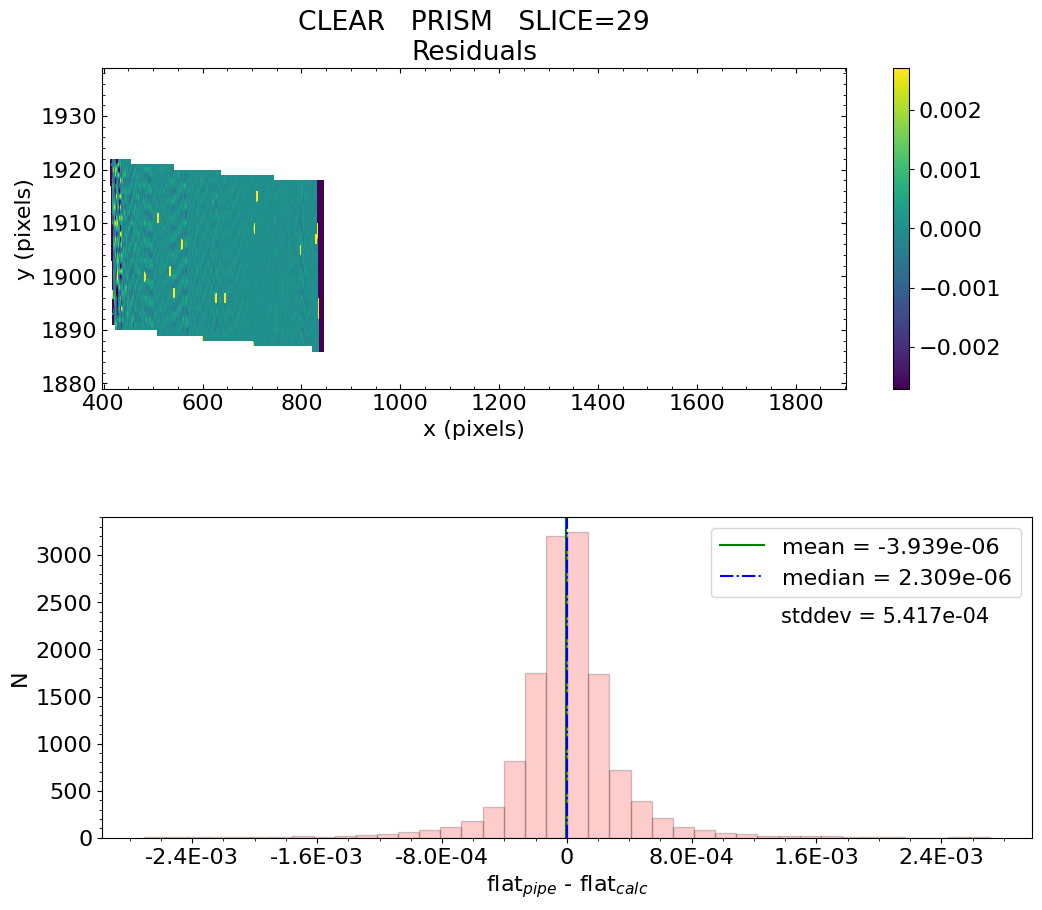

 *** Result of the test: PASSED


 *** Final result for flat_field test will be reported as PASSED *** 

('* Script flattest_ifu.py script took ', '48.10983322461446 minutes to finish.')
Did flat_field for  ifu_prism_clear  validation test passed?  All slices PASSED flat_field test. 


Closing file:  popenfile(path='/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao/ifu_prism_nrs1_interpolatedflat.fits', fd=56, position=16804800, mode='r', flags=557056) 


Closing file:  popenfile(path='/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao/nirspec_dflat_nrs1_f_01.03.fits', fd=57, position=680480640, mode='r', flags=557056) 


Closing file:  popenfile(path='/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao/nirspec_IFU_sflat_PRISM_OPAQUE_FLAT5_nrs1_f_01.01.fits', fd=58, position=50463360, mode='r', flags=557056) 


Closing file:  popenfile(pa

Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao/ifu_prism_nrs2_uncal.fits
Filter =  CLEAR
Running the detector1 pipeline...


2022-10-05 22:01:52,428 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-10-05 22:01:52,461 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-05 22:01:52,462 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-05 22:01:52,464 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-05 22:01:52,465 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-05 22:01:52,466 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-05 22:01:52,467 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-05 22:01:52,468 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-05 22:01:52,469 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-05 22:01:52,470 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-05 22:01:52,471 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-05 22:01:52,472 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-05 22:01:52,473 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-05 22:01:52,475 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-05 22:01:52,476 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-05 22:01:52,478 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-05 22:01:52,479 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-05 22:01:52,480 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-05 22:01:54,018 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao/ifu_prism_nrs2_uncal.fits',).


2022-10-05 22:01:54,033 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-10-05 22:01:54,247 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'ifu_prism_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-05 22:01:54,262 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0143.fits'.


2022-10-05 22:01:54,264 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits'.


2022-10-05 22:01:54,266 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0021.fits'.


2022-10-05 22:01:54,267 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits'.


2022-10-05 22:01:54,269 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-05 22:01:54,269 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits'.


2022-10-05 22:01:54,271 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-05 22:01:54,271 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-05 22:01:54,272 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-10-05 22:01:54,272 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0021.fits'.


2022-10-05 22:01:54,273 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0104.fits'.


2022-10-05 22:01:54,275 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-05 22:01:54,275 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-05 22:01:54,276 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-05 22:01:55,061 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:01:55,063 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 22:01:55,296 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-05 22:01:55,297 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-05 22:01:55,300 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-05 22:01:55,577 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:01:55,581 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 22:01:55,605 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits


2022-10-05 22:01:56,424 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-05 22:01:56,663 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:01:56,666 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao', 'n_pix_grow_sat': 1}


2022-10-05 22:01:56,687 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0021.fits


2022-10-05 22:01:59,185 - stpipe.Detector1Pipeline.saturation - INFO - Detected 21237 saturated pixels


2022-10-05 22:01:59,228 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-05 22:01:59,244 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-05 22:01:59,481 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:01:59,484 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 22:01:59,484 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-05 22:01:59,487 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-05 22:01:59,673 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:01:59,675 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 22:01:59,699 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0104.fits


2022-10-05 22:02:01,622 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-05 22:02:01,814 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:02:01,816 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-05 22:02:02,006 - stpipe.Detector1Pipeline.refpix - INFO - NIR full frame data


2022-10-05 22:02:02,007 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are valid for this mode:


2022-10-05 22:02:02,007 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-10-05 22:02:02,008 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-10-05 22:02:02,008 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-10-05 22:02:02,009 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-10-05 22:02:02,009 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is not applicable and is ignored:


2022-10-05 22:02:02,009 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-10-05 22:02:06,468 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-05 22:02:06,696 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:02:06,697 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 22:02:06,720 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0021.fits


2022-10-05 22:02:10,802 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-05 22:02:11,003 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:02:11,005 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao', 'dark_output': None}


2022-10-05 22:02:11,043 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0143.fits


2022-10-05 22:02:14,988 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-05 22:02:14,989 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-05 22:02:15,414 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-05 22:02:15,618 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:02:15,620 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-05 22:02:15,630 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-05 22:02:15,644 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-10-05 22:02:15,925 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits


2022-10-05 22:02:16,818 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-05 22:02:16,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-10-05 22:02:20,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13747 pixels with at least one CR from five or more groups.


2022-10-05 22:02:20,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 22:02:20,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-05 22:02:23,080 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.26047 sec


2022-10-05 22:02:23,085 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.455536


2022-10-05 22:02:23,092 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-05 22:02:23,362 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:02:23,363 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-05 22:02:23,398 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits


2022-10-05 22:02:23,399 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-10-05 22:02:23,508 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-05 22:02:23,509 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-05 22:03:05,790 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2022-10-05 22:03:05,791 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-10-05 22:03:06,005 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-05 22:03:06,223 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:03:06,225 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 22:03:06,299 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-05 22:03:06,300 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-05 22:03:06,305 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-05 22:03:06,501 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:03:06,502 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpi4ljujao'}


2022-10-05 22:03:06,572 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-05 22:03:06,573 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-05 22:03:06,578 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-05 22:03:06,578 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-05 22:03:06,579 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-05 22:03:06,579 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-05 22:03:06,621 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-05 22:03:06,623 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-05 22:03:06,624 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-05 22:03:06,625 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-05 22:03:06,627 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-05 22:03:06,628 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-05 22:03:06,631 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-05 22:03:06,632 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-05 22:03:06,633 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-05 22:03:06,634 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-05 22:03:06,636 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-05 22:03:06,637 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-05 22:03:06,638 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-05 22:03:06,639 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-05 22:03:06,640 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-05 22:03:06,641 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-05 22:03:06,642 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-05 22:03:06,643 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-05 22:03:06,645 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-05 22:03:06,646 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-05 22:03:06,648 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-05 22:03:06,649 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-05 22:03:06,651 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-05 22:03:06,840 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs2_uncal.fits>,).



Running the spec2 pipeline...


2022-10-05 22:03:06,854 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix

2022-10-05 22:03:06,863 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'ifu_prism_nrs2_uncal.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-05 22:03:06,883 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf'.


2022-10-05 22:03:06,886 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf'.


2022-10-05 22:03:06,888 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dflat_0002.fits'.


2022-10-05 22:03:06,889 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0034.asdf'.


2022-10-05 22:03:06,891 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2022-10-05 22:03:06,891 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fflat_0007.fits'.


2022-10-05 22:03:06,893 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-05 22:03:06,893 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2022-10-05 22:03:06,894 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0028.asdf'.


2022-10-05 22:03:06,895 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf'.


2022-10-05 22:03:06,897 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2022-10-05 22:03:06,897 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_ifufore_0003.asdf'.


2022-10-05 22:03:06,898 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_ifupost_0004.asdf'.


2022-10-05 22:03:06,900 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_ifuslicer_0003.asdf'.


2022-10-05 22:03:06,902 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2022-10-05 22:03:06,902 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf'.


2022-10-05 22:03:06,904 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json'.


2022-10-05 22:03:06,905 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf'.


2022-10-05 22:03:06,907 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-05 22:03:06,907 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_sflat_0052.fits'.


2022-10-05 22:03:06,909 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-05 22:03:06,909 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-05 22:03:06,910 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf'.


2022-10-05 22:03:06,911 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-05 22:03:06,912 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-05 22:03:06,966 - stpipe.Spec2Pipeline - INFO - Processing product ifu_prism_nrs2_uncal


2022-10-05 22:03:06,967 - stpipe.Spec2Pipeline - INFO - Working on input <IFUImageModel(2048, 2048) from ifu_prism_nrs2_uncal.fits> ...


2022-10-05 22:03:07,166 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-05 22:03:07,168 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-05 22:03:07,313 - stpipe.Spec2Pipeline.assign_wcs - CRITICAL - No IFU slices fall on detector NRS2


2022-10-05 22:03:07,314 - stpipe.Spec2Pipeline - ERROR - Assign_wcs processing was skipped.


2022-10-05 22:03:07,314 - stpipe.Spec2Pipeline - ERROR - Aborting remaining processing for this exposure.


2022-10-05 22:03:07,315 - stpipe.Spec2Pipeline - ERROR - No output product will be created.


* Spec2 pipeline CRASHED or exited with no output for detector  nrs2
  Skipping test for this file. 

Did flat_field for  ifu_prism_clear  validation test passed?  skipped 




In [8]:
# Get data for IFU

for mode_config, data_set_dict in testing_data.items():
    if 'ifu' not in mode_config:
        continue
        
    print('Starting to run pipeline and test for mode: ', mode_config)
    
    for detector in detectors:
        print('Testing files for detector: ', detector)
        data = get_artifactory_file(data_set_dict, detector)
        uncal_file, sflat, fflat, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        dflat = dflat_nrs1
        if '2' in detector:
            dflat = dflat_nrs2
        
        # Make sure these keywords are properly set
        filt = fits.getval(uncal_file, 'FILTER')
        if 'OPAQUE' in filt or 'allslits' in uncal_basename.lower():
            if 'clear' in uncal_basename.lower():
                filt = 'CLEAR'
            else:
                l = uncal_basename.split("_")
                for li in l:
                    if 'lp' in li.lower():
                        filt = li
                        break
            fits.setval(uncal_file, 'FILTER', value=filt)
        print('Filter = ', filt)

        # Run the stage 1 pipeline 
        print('Running the detector1 pipeline...')
        rate_object = Detector1Pipeline.call(uncal_file)
        
        # Make sure the FXD_SLIT keyword is set correctly
        try:
            if 'full' in rate_object.meta.instrument.fixed_slit:
                rate_object.meta.instrument.fixed_slit = 'NONE'
        except TypeError:
            print('FXD_SLIT keyword = ', rate_object.meta.instrument.fixed_slit)
        
        # Run the stage 2 pipeline steps
        print('\nRunning the spec2 pipeline...')
        skip_file = False
        try:
            parameter_dict = {"flat_field": {"save_interpolated_flat": True},
                              "pathloss": {"skip": True},
                              "barshadow": {"skip": True},
                              "photom": {"skip": True},
                              "resample_spec": {"skip": True},
                              "cube_build": {"skip": True},
                              "extract_1d": {"skip": True}
                             }
            flat_field_object = Spec2Pipeline.call(rate_object, steps=parameter_dict)
        except:
            #print("No open slits fall on detector ", det)  # usually why assign_wcs crashes
            print("* Spec2 pipeline CRASHED or exited with no output for detector ", detector)
            print("  Skipping test for this file. \n")
            skip_file = True
            
        if not skip_file:   
            # accepted threshold difference with respect to benchmark files
            threshold_diff = 9.999e-5
            if 'prism' in uncal_basename.lower():
                threshold_diff = 9.999e-3
            
            # Run the validation test
            %matplotlib inline
            interpolated_flat = os.path.basename(uncal_file).replace('uncal', 'interpolatedflat')
            print('Running flat field test for IFU...')
            result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_ifu.flattest(
                                                                            flat_field_object,
                                                                            dflat_path=dflat,
                                                                            sflat_path=sflat, 
                                                                            fflat_path=fflat,
                                                                            writefile=writefile,
                                                                            mk_all_slices_plt=False, 
                                                                            show_figs=show_figs, 
                                                                            save_figs=save_figs,
                                                                            interpolated_flat=interpolated_flat,
                                                                            threshold_diff=threshold_diff,
                                                                            debug=False)
        else:
            result, result_msg = 'skipped', 'skipped'

        # Did the test passed 
        print("Did flat_field for ", mode_config, " validation test passed? ", result_msg, "\n\n")
        rd = {uncal_basename: result}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                print('Closing file: ', fd, '\n\n')
                open(fd.fd).close()
            except:
                print('File already closed: ', fd, '\n\n')


In [9]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    if not isinstance(val, str):
        if val:
            val = 'PASSED'
        else:
            val = 'FAILED'
    print('{:<42} {:<8}'.format(key, val))


These are the final results of the tests: 
ifu_prism_nrs1_uncal.fits                  PASSED  
ifu_prism_nrs2_uncal.fits                  skipped 


<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Sr. Science Software Engineer, NIRSpec
<br>**Updated On:** Sep/23/2022

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 